# CODEATHON 2: Recognizing UVA landmarks with neural nets (50 pts)
![UVA Grounds](https://giving.virginia.edu/sites/default/files/2019-02/jgi-teaser-image.jpg) 

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture. 

In this codeathon, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 50 points for this codeathon plus 10 bonus points. To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb file via UVA Collab with the following format: yourcomputingID_codeathon_2.ipynb

In [ ]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import scipy.ndimage as ndimage


%tensorflow_version 2.8.3
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Step 2: Process the  Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

Lets get some thoughts done before I forget them. 

This would be trivial if I could just create a model for each building and try to assign the image that I receive to one of the models. But I don't think I'm supposed to do that. All of the identifying "knowledge" should be innate to the model and not some external model that is developed. So I think the model needs to be able to recognize architectural motifs that are unique to each building. 

So a large focus has to be on the shape of the windows, the shape of the roof, the presence/shape of columns, etc. So whatever algorithm I create should be able to distinguish and identify those features. This is particularly important considering that most pictures feature the building as a very small part of the overall landscape or otherwise apply some distortion or another to the building. 

The dataset itself is another factor entirely. So the images are 300x300 pixels in size. Which isn't that good (very low res). But still should be workable? Further, I've noticed that there's ~1 image per building picture set that is very bad. Consider BrooksHall 00000002778, a picture of a picture. Or consider 0000005100 of NewCabellHall which is obviously a picture of the church instead. Or pictures 0000005147-0000005182 which prominently feature a blue truck. This dataset requires a lot of reorganization. 

But it probably isn't worth reorganizing. Lets see if I can deal with it later. 




In [ ]:
# Download dataset from Firebase
!wget https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7

--2022-12-01 01:47:16--  https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 74.125.24.95, 172.217.194.95, 142.251.10.95, ...
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|74.125.24.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397174132 (379M) [application/zip]
Saving to: ‘dataset.zip?alt=media’

dataset.zip?alt=med 100%[===================>] 378.77M  23.1MB/s    in 17s     

2022-12-01 01:47:34 (21.9 MB/s) - ‘dataset.zip?alt=media’ saved [397174132/397174132]



In [ ]:
# Extract content
!unzip "/content/dataset.zip?alt=media"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Rotunda/0000010694.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010694.jpg  
  inflating: dataset/Rotunda/0000010680.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010680.jpg  
  inflating: dataset/Rotunda/0000010858.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010858.jpg  
  inflating: dataset/Rotunda/0000010870.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010870.jpg  
  inflating: dataset/Rotunda/0000010864.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010864.jpg  
  inflating: dataset/Rotunda/0000010865.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010865.jpg  
  inflating: dataset/Rotunda/0000010871.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010871.jpg  
  inflating: dataset/Rotunda/0000010859.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010859.jpg  
  inflating: dataset/Rotunda/0000010681.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010681.jpg  
  inflating: dataset/R

In [ ]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 227; 
img_width = 227;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        

Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


In [ ]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
train_ds._batch_size

<tf.Tensor: shape=(), dtype=int64, numpy=32>

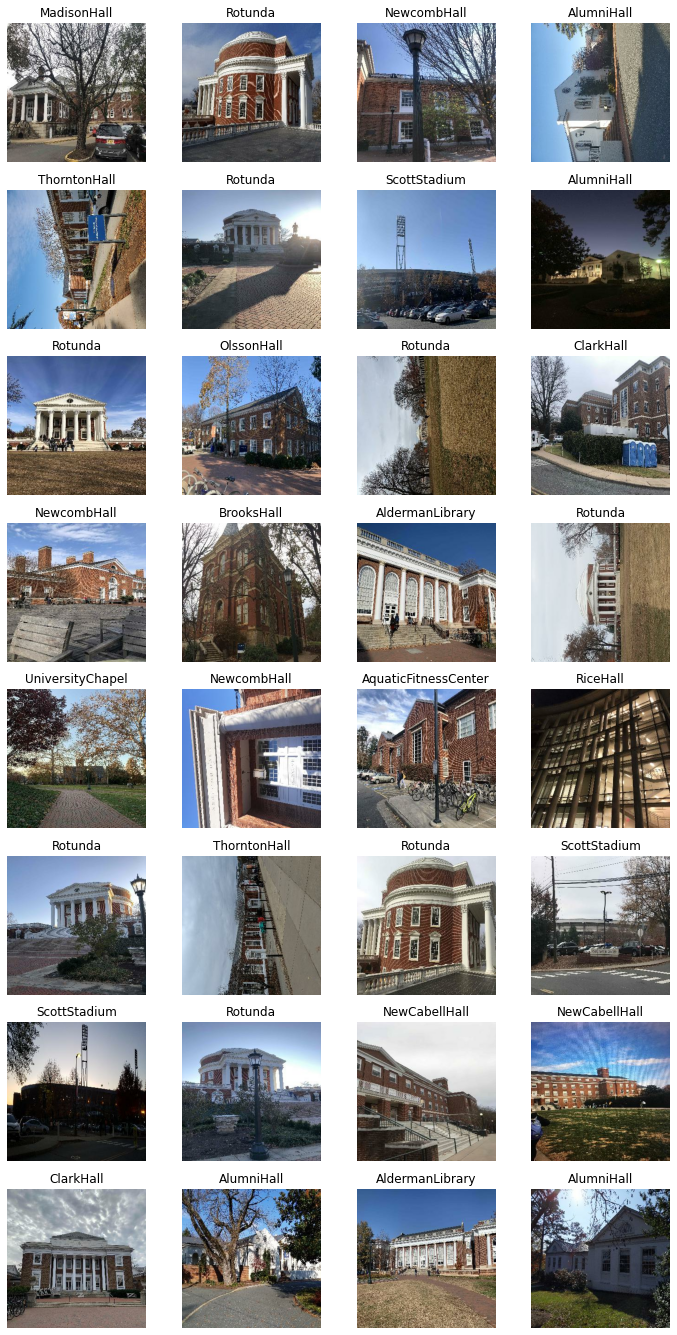

In [ ]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[np.argmax(labels[i])], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


Ngl, for some of these pictures even I wouldn't be able to recognize them. Matter of fact, I don't even think I've seen these buildings this semester, if at all. But that's just a symptom of CS in the E-school.

Here is where we need to do some data augmentation. But we need to do thse transformations intelligently such that the model can still pick-up on relevant features. As such, we need the transformations to respect the following ideas: 
1.   The dataset should be rotation agnostic
2.   The dataset should be day/night agnostic
3.   The dataset should be size agnostic
4.   The dataset should be color agnostic?
5.   The dataset should be translation agnostic 

The second one is the most problematic as I cannot generate day/night images automatically. Because at night some buildings have lights at unique location which really doesn't help. 

Four might also be helpful so we can tell the model to care most about architecture and stuff like that instead of brick color and the like.  

Also don't want to flip image as that is non-sensical in this context. I haven't seen any images that are reversed. So it doesn't make sense to flip the image in training because we would never see that image during testing. 

Another thing is that we want to ensure that the training/validation accuracies are in-line but I think that having sufficient data augmentation will take care of this. 

In [ ]:
data_augmentation = keras.models.Sequential(
    [
        tf.keras.layers.Resizing(height=300, width=300), 
        tf.keras.layers.RandomRotation((-0.5, 0.5), "reflect", "bilinear"),
        # constant is just a black fill
        # reflect is interesting but probably undesirable, produces interesting result when 
        # when image is upside down
        # wrap fills in from the bottom
        # and nearest: just pulls down the edge of the image
     
        # will be using bilinear for the third option as it uses WA 
        # nearest introduces too much blockiness
     
        # guassian noise: 
        tf.keras.layers.GaussianNoise(10), # making the stddev for this 10, can't see a diff with 1

        # color based changes: 
        tf.keras.layers.RandomBrightness(0.2, value_range=(0, 255)), # maybe decrease this? 
        # not bad for silhouettes but still questionable
        tf.keras.layers.RandomContrast(1),

        # zoom/translate changes: 
        # maybe have randomCrop, randomZoom? (What if we zoom into the wrong thing like the sky?)
        tf.keras.layers.RandomHeight((-0.2, 0.2), "bilinear"), # this would be fine for adding distortion
        tf.keras.layers.RandomWidth((-0.2, 0.2), "bilinear"),
        # but need to reshape at the end 
        tf.keras.layers.RandomTranslation((-0.1, 0.1), (-0.1, 0.1), "nearest", "bilinear"),
        tf.keras.layers.Resizing(300,300)

    ]
)
data_augmentation._name="data_aug"

In [ ]:
final_data_augmentation = keras.models.Sequential(
    [
        tf.keras.layers.RandomRotation((-0.5, 0.5), "reflect", "bilinear"),
        tf.keras.layers.RandomCrop(height=227, width=227),
        tf.keras.layers.GaussianNoise(1), # making the stddev for this 10, can't see a diff with 1 
        tf.keras.layers.RandomZoom(
          height_factor=0.3,
          width_factor=0.3,
          fill_mode='reflect',
          interpolation='bilinear') # effectively does some shearing

    ],
    name="final_data_aug"
)


/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


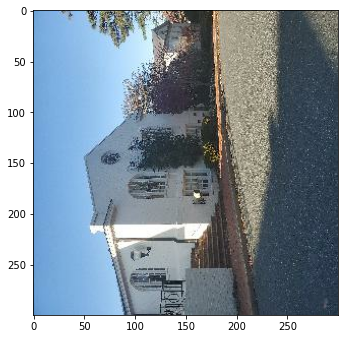

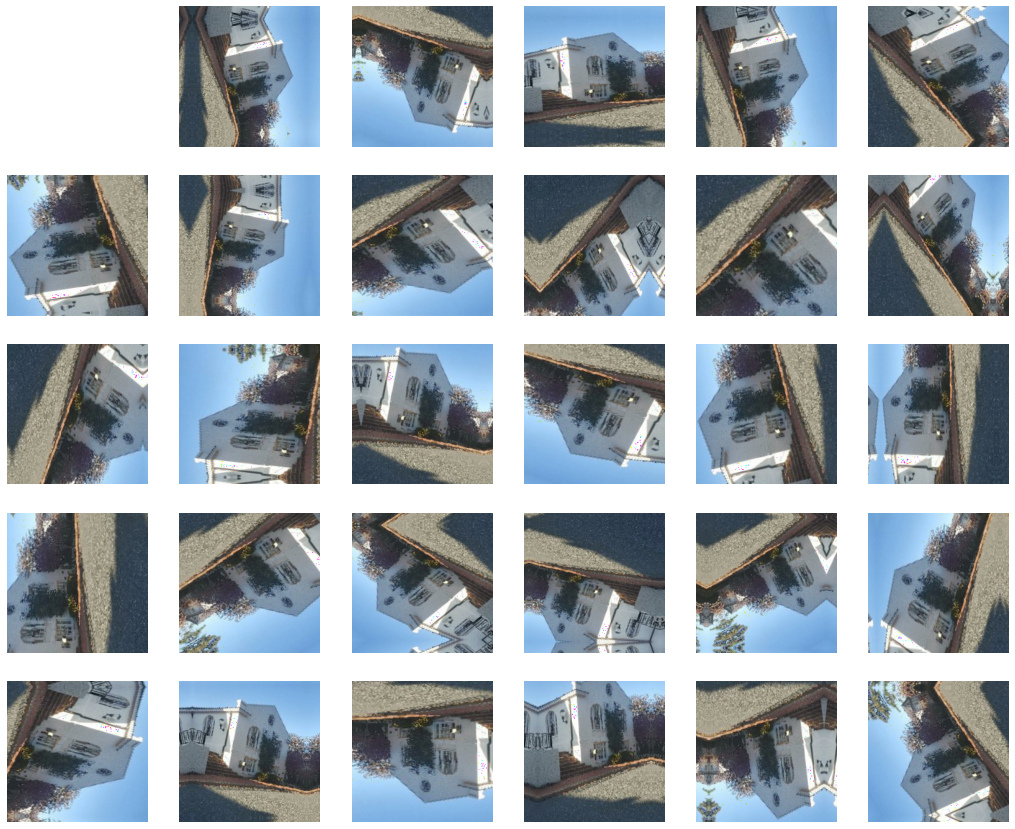

In [ ]:
plt.figure(figsize=(12, 24))

image = images[3] # the way we initially get images is hacky (from the for-loop)
plt.subplot(1, 2, 1)
plt.imshow(image.numpy().astype("uint8"))
tf.keras.backend.set_learning_phase(1) # to set training mode globally

n_rows = 5
n_cols = 6
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for i in range (1, n_rows*n_cols):
    aug_image = final_data_augmentation(image)
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(aug_image.numpy().astype("uint8"))
    plt.axis('off')
plt.subplots_adjust(wspace=.2, hspace=.2)

tf.keras.backend.set_learning_phase(0)

# Step 3: Create your own CNN architecture
You must design your own architecture. To get started, you may get inspiration from one in CNN notebook  (i.e. use one similar to LeNet-5 or AlexNet). You will have to report the design of the architecture:

1.   How many layers does it have? 
2.   Why do you decide on a certain number nodes per layer? 
3.   Which activation functions do you choose? 
4.   How many parameters does it has in total?

Hint: use `myModel.summary()` to learn on the layers and parameters




A lot of the following code is from: https://github.com/Prajwal10031999/Plant-Diseases-Classification-using-AlexNet/blob/main/plant-disease-prediction.ipynb

In [ ]:
AlexNet_model  = keras.models.Sequential([
    keras.Input((227, 227, 3)),
    # final_data_augmentation, # was told to remove augmentation by TA 
    keras.layers.BatchNormalization(), 

    # Convolution Step 1
    keras.layers.Conv2D(filters=96, kernel_size=11, strides = (4, 4), padding = 'valid', input_shape=(227, 227, 3), activation = 'relu'),
    
    # Max Pooling Step 1
    keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'),
    keras.layers.BatchNormalization(),
    
    # Convolution Step 2
    keras.layers.Conv2D(filters=256, kernel_size=11, strides = (1, 1), padding='valid', activation='relu'),
    
    # Max Pooling Step 2
    keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'),
    keras.layers.BatchNormalization(),

    # Convoltion Step 3
    keras.layers.Conv2D(filters=384, kernel_size=3, strides = (1, 1), padding='valid', activation='relu'),
    keras.layers.BatchNormalization(),

    # Convolution Step 4
    keras.layers.Conv2D(filters=384, kernel_size=3, strides = (1, 1), padding='valid', activation='relu'),
    keras.layers.BatchNormalization(),

    # Convolution Step 5
    keras.layers.Conv2D(filters=256, kernel_size=3, strides = (1, 1), padding='valid', activation='relu'),

    # Max Pooling Step 3
    keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'),
    keras.layers.BatchNormalization(),

    # Flattening
    keras.layers.Flatten(),

    # Full Connection
    keras.layers.Dense(units=4096, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(units=4096, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(units=4096, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(units=18, activation='softmax'),
])

AlexNet_model.build()
AlexNet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_9 (Batc  (None, 227, 227, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 27, 27, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                      

## Answering Architecture Questions: 

1.   How many layers does it have? 

We're using a basic AlexNet architecture with only one augmentation, a BatchNormalization layer before the first convolution layer and no augmentation. I've played with this model in another notebook and haven't found an architecture that diverges from this and significantly improves performance. With this model as it is, it's difficult if not impossible to improve performance further. 

2.   Why do you decide on a certain number nodes per layer? 

The first part of the model is pretty standard. I'm using AlexNet's standard input format because increasing input size doesn't help much with performance and decreasing input size significantly improves training speed. 

\begin{equation}
n_{out} = \left\lfloor \frac{n_{in} + 2 * p - k}{s} \right\rfloor + 1
\end{equation}

Where n_out/n_in are the nodes in/out p is the convolution padding size, k is the convolution kernel size, and s is the convolution stride size. 

The above equation was used to determine appropriate stride, kernel and input/output sizes. 

I'm making a significant design decision/trade-off between resizing the model to take 300x300 images vs leaving the model at 227x227. 

On the one hand resizing the model to 300x300 would allow the model to get the maximum image input size, thereby allowing it to extract the maximum data from the image. 

Resizing, on the other hand allows for me to respect the model's original design, something that I found is actually really important. Within resizing, we have two options: 

1. Resize the image 300x300 --> 227x227
2. RandomCrop the image to 227x227

Admittedly, the RandomCrop doesn't feel the best but considering that I don't have most of the keras augmentation layers available to me, I'll take the randomCrop and employ it as effectively a combination of RandomZoom/RandomTranslate. Its better than not having many augmentation layers or having to do some crop/resize the image to a smaller image and potentially losing out on performance gains. 

I actually decided to go with importing the image as a 227x227 image and calling it a day with no data augmentation. 

3.   Which activation functions do you choose? 

I left the model with ReLU except for the top of the model which is a fully connected neural net which has all ReLU with a Softmax decision layer. 

4.   How many parameters does it has in total?

We have 40,850,206 params of which 40,822,872 are trainable and 27,334 are non-trainable. 

What I found most notable from all the experimentation I did was that the mode of training matters a lot more than the actual model. Obviously having a strong model is good but with my resources AlexNet is what I can most reliably train from scratch. Better models require far too many resources for my meager means. 

But speaking of training, I have the following schema I want to try: 

1. Train the entire model
2. Freeze the AlexNet part, let the Neural Network train
3. Un-freeze everything and resume training, albeit at a very low training rate. 

After designing the model, you will need to train it. In order to train, you will need to pick a number of `epoch` (iteration), which `optimizer` to use (from  `keras.optimizers`), a `loss` function, and some `metrics`.

In [ ]:
# generating class weights: 
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

y = np.concatenate([y for x, y in train_ds], axis=0)
train_class_weights = generate_class_weights(y, multi_class=True, one_hot_encoded=True)
print(train_class_weights)

{0: 1.9299223235393448, 1: 1.0689300411522633, 2: 1.6931851851851851, 3: 1.4496448503297819, 4: 3.670199100834939, 5: 1.924074074074074, 6: 0.943453855043751, 7: 2.1024650478292863, 8: 1.0307539682539681, 9: 1.2548309178743962, 10: 1.1042512077294686, 11: 0.9548036758563074, 12: 0.8140313390313391, 13: 0.5399187452758881, 14: 0.5027271927509457, 15: 0.6485642946317104, 16: 0.6492274483072029, 17: 0.9378795338913507}


In [ ]:
myEpochs = 100
myOptimizer = "nadam"
myLoss = "categorical_crossentropy" # because we have numerical lables and mult categories
myMetrics = ['accuracy', 'categorical_crossentropy']

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  min_delta=0.1,
                                                  patience=10, 
                                                  verbose=1, 
                                                  mode='max', 
                                                  restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

AlexNet_model.compile(loss= myLoss, optimizer = myOptimizer, metrics = myMetrics)
history0 = AlexNet_model.fit( train_ds, 
                      validation_data=validation_ds, 
                      epochs = myEpochs, 
                      class_weight = train_class_weights, 
                      callbacks = [reduce_lr, early_stopping_cb])

Epoch 1/100
358/358 [==============================] - 35s 87ms/step - loss: 2.5672 - accuracy: 0.3600 - categorical_crossentropy: 2.7082 - val_loss: 8.3776 - val_accuracy: 0.3042 - val_categorical_crossentropy: 8.3776 - lr: 0.0010
Epoch 2/100
358/358 [==============================] - 31s 85ms/step - loss: 2.1906 - accuracy: 0.4251 - categorical_crossentropy: 2.3387 - val_loss: 2.1561 - val_accuracy: 0.4344 - val_categorical_crossentropy: 2.1561 - lr: 0.0010
Epoch 3/100
358/358 [==============================] - 31s 85ms/step - loss: 2.0361 - accuracy: 0.4891 - categorical_crossentropy: 2.1552 - val_loss: 3.9460 - val_accuracy: 0.2972 - val_categorical_crossentropy: 3.9460 - lr: 0.0010
Epoch 4/100
358/358 [==============================] - 31s 85ms/step - loss: 2.2166 - accuracy: 0.4358 - categorical_crossentropy: 2.3484 - val_loss: 3.1241 - val_accuracy: 0.4099 - val_categorical_crossentropy: 3.1241 - lr: 0.0010
Epoch 5/100
358/358 [==============================] - 34s 93ms/step - l

In [ ]:
AlexNet_model.save("/content/AlexNet_step0_model.h5")

In [ ]:
# inspecting layers in model: 
for i, layer in enumerate(AlexNet_model.layers):
   print(i, layer.name)

0 batch_normalization_9
1 conv2d_5
2 max_pooling2d_3
3 batch_normalization_10
4 conv2d_6
5 max_pooling2d_4
6 batch_normalization_11
7 conv2d_7
8 batch_normalization_12
9 conv2d_8
10 batch_normalization_13
11 conv2d_9
12 max_pooling2d_5
13 batch_normalization_14
14 flatten_1
15 dense_4
16 dropout_3
17 batch_normalization_15
18 dense_5
19 dropout_4
20 batch_normalization_16
21 dense_6
22 dropout_5
23 batch_normalization_17
24 dense_7


Looking at this, we need to freeze layers 0-13

In [ ]:
AlexNet_model.trainable = True

In [ ]:
print("Freezed layers:")
for i, layer in enumerate(AlexNet_model.layers[:14]):
    print(i, layer.name)
    layer.trainable = False

Freezed layers:
0 batch_normalization_9
1 conv2d_5
2 max_pooling2d_3
3 batch_normalization_10
4 conv2d_6
5 max_pooling2d_4
6 batch_normalization_11
7 conv2d_7
8 batch_normalization_12
9 conv2d_8
10 batch_normalization_13
11 conv2d_9
12 max_pooling2d_5
13 batch_normalization_14


Fine tuning the fully connected layer

In [ ]:
myEpochs = 10
myOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)
myLoss = "categorical_crossentropy" # because we have numerical lables and mult categories
myMetrics = ['accuracy', 'categorical_crossentropy']
AlexNet_model.compile(loss= myLoss, optimizer = myOptimizer, metrics = myMetrics)
history1 = AlexNet_model.fit( train_ds, 
                      validation_data=validation_ds, 
                      epochs = myEpochs, 
                      class_weight = train_class_weights,
                      callbacks = [early_stopping_cb])

Epoch 1/10
358/358 [==============================] - 30s 78ms/step - loss: 22.7738 - accuracy: 0.4286 - categorical_crossentropy: 24.0388 - val_loss: 86.3357 - val_accuracy: 0.4064 - val_categorical_crossentropy: 86.3357
Epoch 2/10
358/358 [==============================] - 23s 63ms/step - loss: 76.1208 - accuracy: 0.5251 - categorical_crossentropy: 81.1031 - val_loss: 230.9487 - val_accuracy: 0.4869 - val_categorical_crossentropy: 230.9487
Epoch 3/10
358/358 [==============================] - 25s 69ms/step - loss: 83.6193 - accuracy: 0.6163 - categorical_crossentropy: 90.4246 - val_loss: 94.6513 - val_accuracy: 0.5887 - val_categorical_crossentropy: 94.6513
Epoch 4/10
358/358 [==============================] - 36s 99ms/step - loss: 68.7429 - accuracy: 0.6197 - categorical_crossentropy: 73.1190 - val_loss: 130.1911 - val_accuracy: 0.5194 - val_categorical_crossentropy: 130.1911
Epoch 5/10
358/358 [==============================] - 28s 77ms/step - loss: 53.2445 - accuracy: 0.6611 - cat

In [ ]:
AlexNet_model.save("/content/AlexNet_step1_model.h5")

In [ ]:
AlexNet_model.trainable = True

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  min_delta=0.01,
                                                  patience=10, 
                                                  verbose=1, 
                                                  mode='max', 
                                                  restore_best_weights=True)

myEpochs = 50
myOptimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, decay=0.005)
myLoss = "categorical_crossentropy" # because we have numerical lables and mult categories
myMetrics = ['accuracy', 'categorical_crossentropy']
AlexNet_model.compile(loss= myLoss, optimizer = myOptimizer, metrics = myMetrics)
history2 = AlexNet_model.fit( train_ds, 
                      validation_data=validation_ds, 
                      epochs = myEpochs, 
                      class_weight = train_class_weights,
                      callbacks = [early_stopping_cb, reduce_lr])

Epoch 1/10
358/358 [==============================] - 28s 75ms/step - loss: 31.1662 - accuracy: 0.6945 - categorical_crossentropy: 32.6011 - val_loss: 73895832.0000 - val_accuracy: 0.6510 - val_categorical_crossentropy: 73895832.0000 - lr: 1.0000e-04
Epoch 2/10
358/358 [==============================] - 26s 70ms/step - loss: 24.5556 - accuracy: 0.7230 - categorical_crossentropy: 26.6787 - val_loss: 59542568.0000 - val_accuracy: 0.6790 - val_categorical_crossentropy: 59542568.0000 - lr: 1.0000e-04
Epoch 3/10
358/358 [==============================] - 26s 72ms/step - loss: 23.8036 - accuracy: 0.7293 - categorical_crossentropy: 25.8359 - val_loss: 12967844.0000 - val_accuracy: 0.6909 - val_categorical_crossentropy: 12967844.0000 - lr: 1.0000e-04
Epoch 4/10
358/358 [==============================] - 31s 85ms/step - loss: 21.7147 - accuracy: 0.7366 - categorical_crossentropy: 24.1070 - val_loss: 35399076.0000 - val_accuracy: 0.6920 - val_categorical_crossentropy: 35399076.0000 - lr: 1.0000e

In [ ]:
AlexNet_model.save("/content/AlexNet_step2_model.h5")

Next, you need to create (1) a plot of training and validation `loss` and (2) a plot of training and validation `accuracy`. These plots might give you some insights about your model performance and possibility of overfitting.

Report the performance of your architecture on the validation set in a `confusion matrix`. Make comments on the performance by answering the following questiosns:
- How well do you think your architecture is doing (overall accuracy)? 
- Where did it makes mistake most? 
- Which classes can be improved?

In [ ]:
IMG_SIZE = 227

# extracting all the data: 
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    seed = 42, 
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size, 
    shuffle=False
)

Found 14286 files belonging to 18 classes.


In [ ]:
y_pred = AlexNet_model.predict(test_ds).argmax(axis=-1)
test_labels = np.argmax(np.concatenate([y for x, y in test_ds], axis = 0), axis=1)

447/447 [==============================] - 22s 48ms/step


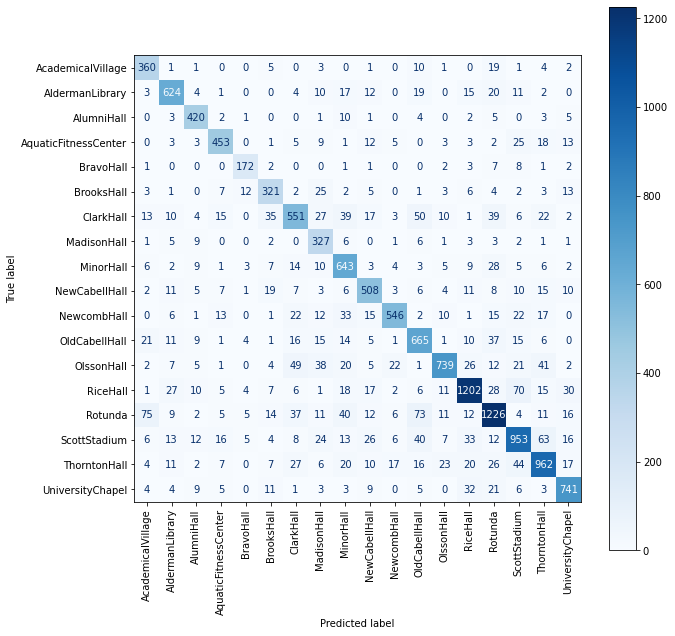

In [ ]:
# from: https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

labels = train_ds.class_names
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
print("Evaluate on test data")
results = AlexNet_model.evaluate(test_ds, batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data
447/447 [==============================] - 21s 46ms/step - loss: 102356920.0000 - accuracy: 0.7989 - categorical_crossentropy: 102356920.0000
test loss, test acc: [102356920.0, 0.7988940477371216, 102356920.0]


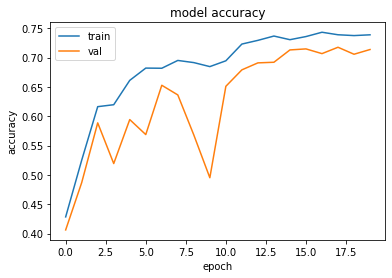

In [ ]:
plt.plot(history0.history['accuracy'] + history1.history['accuracy'] + history2.history['accuracy'])
plt.plot(history0.history['val_accuracy'] + history1.history['val_accuracy'] + history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

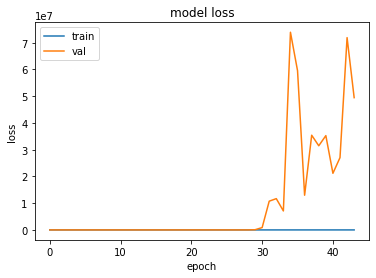

In [ ]:
plt.plot(history0.history['loss'] + history1.history['loss'] + history2.history['loss'])
plt.plot(history0.history['val_loss'] + history1.history['val_loss'] + history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(sklearn.metrics.classification_report(test_labels, y_pred, target_names=labels))

                      precision    recall  f1-score   support

   AcademicalVillage       0.72      0.88      0.79       408
     AldermanLibrary       0.83      0.84      0.84       742
          AlumniHall       0.83      0.92      0.87       457
AquaticFitnessCenter       0.84      0.81      0.83       556
           BravoHall       0.83      0.86      0.85       200
          BrooksHall       0.73      0.78      0.75       410
           ClarkHall       0.74      0.65      0.69       844
         MadisonHall       0.62      0.89      0.73       368
           MinorHall       0.73      0.85      0.78       760
       NewCabellHall       0.77      0.80      0.78       636
         NewcombHall       0.89      0.76      0.82       716
       OldCabellHall       0.73      0.80      0.76       832
          OlssonHall       0.89      0.74      0.81       995
            RiceHall       0.87      0.82      0.84      1460
             Rotunda       0.81      0.78      0.80      1569
       

## Answering Evaluation Questions

This looks pretty good. After weeks of working, the model finally reaches the threshold. 
- How well do you think your architecture is doing (overall accuracy)? 

I think my architecture does pretty well, the overall accuracy is 0.7988940477371216. So it's above the threshold which is good. Although the loss is very high, the accuracy is pretty good so I think that's fine. It just means that the model makes few very costly errors. 

- Where did it makes mistake most? 

I hypothesized that the most common mistakes would be misclassifications of the Academic Villages as the Rotunda and vice-versa, mostly because the two are attached and pictures of of them often includes the other. 

While my hypothesis was correct, there were other buildings that were also frequently miscategorized: 
  - Clark Hall as Old Cabell: 50
  - Rotunda as Old Cabell: 73
  - RiceHall as Scott Stadium: 70
  - Scott Stadium as Thornton Hall: 64
  - Rotunda as Clark Hall: 37
  - Olsson as Clark Hall: 49

Interesting it seems to get easily confused for buildings with similar architectures. The Rotunda and Old Cabell were built in almost the same era so they have highly similar architecture. Rice Hall and Scott Stadium doesn't make much sense. Scott Stadium and Thorton are interesting as well. I can't particularly attribute a reason as to why. 

I think a lot of the error can be attributed to a few of the building's classifications. The lowest recall buildings are Clark Hall, the Rotunda, ScottStadium, Olsson Hall, and Thornton. But interestingly the lowest precision buildings are Madison Hall, Academical Village etc. 

- Which classes can be improved?

I think a lot of the E-School building pictures can be improved easily. Particularly decreasing the misclassification of the E-School buildings would probably significantly improve overall class recognition. Additionally, pictures of the buildings in differing lightings (dawn/dusk/daytime/rainy) would also be good. 

In [ ]:
pre_load_model = keras.models.load_model("/content/step8_2_final.h5")

In [ ]:
y_pred = pre_load_model.predict(test_ds).argmax(axis=-1)
test_labels = np.argmax(np.concatenate([y for x, y in test_ds], axis = 0), axis=1)

447/447 [==============================] - 23s 52ms/step


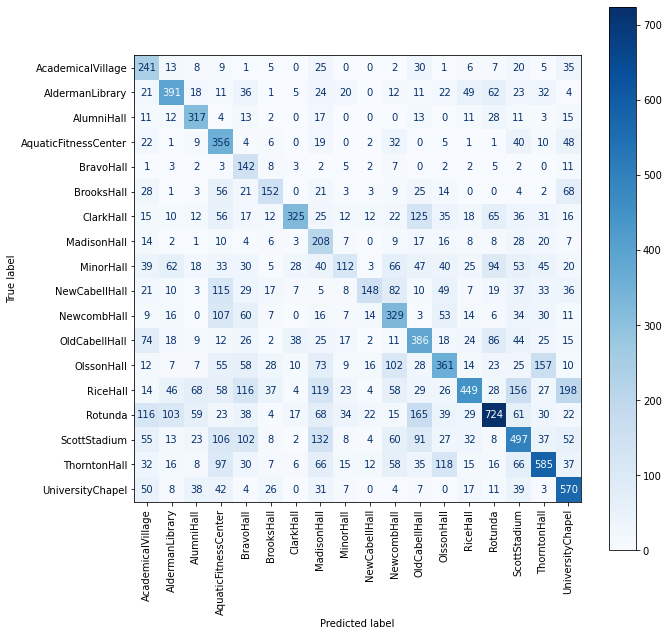

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

labels = train_ds.class_names
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
# Slight issue, cleared the runtime before generating the loss plots so instead 
# I have to use a python script that manually extracts the values from the
# .fit() training text output

s1 = "Epoch 1/10 358/358 [==============================] - ETA: 0s - loss: 3.6129 - Accuracy: 0.1167 Epoch 1: val_loss improved from inf to 3.38124, saving model to /content/step0.h5 358/358 [==============================] - 45s 93ms/step - loss: 3.6129 - Accuracy: 0.1167 - val_loss: 3.3812 - val_Accuracy: 0.1383 Epoch 2/10 357/358 [============================>.] - ETA: 0s - loss: 3.2841 - Accuracy: 0.1432 Epoch 2: val_loss did not improve from 3.38124 358/358 [==============================] - 29s 80ms/step - loss: 3.2839 - Accuracy: 0.1432 - val_loss: 3.3899 - val_Accuracy: 0.1141 Epoch 3/10 357/358 [============================>.] - ETA: 0s - loss: 3.2136 - Accuracy: 0.1613 Epoch 3: val_loss did not improve from 3.38124 358/358 [==============================] - 35s 96ms/step - loss: 3.2133 - Accuracy: 0.1614 - val_loss: 3.4032 - val_Accuracy: 0.2153 Epoch 4/10 357/358 [============================>.] - ETA: 0s - loss: 3.0491 - Accuracy: 0.1746 Epoch 4: val_loss improved from 3.38124 to 2.71004, saving model to /content/step0.h5 358/358 [==============================] - 35s 97ms/step - loss: 3.0490 - Accuracy: 0.1746 - val_loss: 2.7100 - val_Accuracy: 0.2132 Epoch 5/10 357/358 [============================>.] - ETA: 0s - loss: 2.9960 - Accuracy: 0.1958 Epoch 5: val_loss did not improve from 2.71004 358/358 [==============================] - 33s 90ms/step - loss: 2.9969 - Accuracy: 0.1957 - val_loss: 2.9541 - val_Accuracy: 0.1722 Epoch 6/10 357/358 [============================>.] - ETA: 0s - loss: 2.9400 - Accuracy: 0.2075 Epoch 6: val_loss did not improve from 2.71004 358/358 [==============================] - 36s 100ms/step - loss: 2.9397 - Accuracy: 0.2075 - val_loss: 2.8409 - val_Accuracy: 0.2391 Epoch 7/10 357/358 [============================>.] - ETA: 0s - loss: 2.8983 - Accuracy: 0.2119 Epoch 7: val_loss did not improve from 2.71004 358/358 [==============================] - 33s 91ms/step - loss: 2.8983 - Accuracy: 0.2119 - val_loss: 3.9949 - val_Accuracy: 0.1638 Epoch 8/10 357/358 [============================>.] - ETA: 0s - loss: 2.9429 - Accuracy: 0.2015 Epoch 8: val_loss did not improve from 2.71004 358/358 [==============================] - 29s 81ms/step - loss: 2.9434 - Accuracy: 0.2014 - val_loss: 2.9766 - val_Accuracy: 0.1687 Epoch 9/10 357/358 [============================>.] - ETA: 0s - loss: 2.8977 - Accuracy: 0.2192 Epoch 9: val_loss did not improve from 2.71004 358/358 [==============================] - 29s 79ms/step - loss: 2.8973 - Accuracy: 0.2193 - val_loss: 2.7500 - val_Accuracy: 0.1852 Epoch 10/10 357/358 [============================>.] - ETA: 0s - loss: 2.8235 - Accuracy: 0.2266 Epoch 10: val_loss did not improve from 2.71004 358/358 [==============================] - 29s 79ms/step - loss: 2.8230 - Accuracy: 0.2267 - val_loss: 2.8243 - val_Accuracy: 0.2282"
s2 = "Epoch 1/10 358/358 [==============================] - ETA: 0s - loss: 2.9439 - Accuracy: 0.2092 Epoch 1: val_loss improved from inf to 2.56787, saving model to /content/step1.h5 358/358 [==============================] - 30s 79ms/step - loss: 2.9439 - Accuracy: 0.2092 - val_loss: 2.5679 - val_Accuracy: 0.2478 Epoch 2/10 357/358 [============================>.] - ETA: 0s - loss: 2.8649 - Accuracy: 0.2131 Epoch 2: val_loss improved from 2.56787 to 2.49283, saving model to /content/step1.h5 358/358 [==============================] - 29s 80ms/step - loss: 2.8648 - Accuracy: 0.2132 - val_loss: 2.4928 - val_Accuracy: 0.2580 Epoch 3/10 357/358 [============================>.] - ETA: 0s - loss: 2.7631 - Accuracy: 0.2265 Epoch 3: val_loss did not improve from 2.49283 358/358 [==============================] - 27s 74ms/step - loss: 2.7638 - Accuracy: 0.2264 - val_loss: 2.6087 - val_Accuracy: 0.2471 Epoch 4/10 357/358 [============================>.] - ETA: 0s - loss: 2.7762 - Accuracy: 0.2274 Epoch 4: val_loss did not improve from 2.49283 358/358 [==============================] - 27s 75ms/step - loss: 2.7762 - Accuracy: 0.2274 - val_loss: 2.6730 - val_Accuracy: 0.2492 Epoch 5/10 357/358 [============================>.] - ETA: 0s - loss: 2.6883 - Accuracy: 0.2340 Epoch 5: val_loss did not improve from 2.49283 358/358 [==============================] - 27s 74ms/step - loss: 2.6886 - Accuracy: 0.2339 - val_loss: 2.6304 - val_Accuracy: 0.2366 Epoch 6/10 357/358 [============================>.] - ETA: 0s - loss: 2.7064 - Accuracy: 0.2283 Epoch 6: val_loss did not improve from 2.49283 358/358 [==============================] - 27s 74ms/step - loss: 2.7062 - Accuracy: 0.2283 - val_loss: 2.6245 - val_Accuracy: 0.2534 Epoch 7/10 357/358 [============================>.] - ETA: 0s - loss: 2.6770 - Accuracy: 0.2370 Epoch 7: val_loss did not improve from 2.49283 358/358 [==============================] - 27s 74ms/step - loss: 2.6769 - Accuracy: 0.2369 - val_loss: 2.5543 - val_Accuracy: 0.2625 Epoch 8/10 357/358 [============================>.] - ETA: 0s - loss: 2.6436 - Accuracy: 0.2447 Epoch 8: val_loss did not improve from 2.49283 358/358 [==============================] - 26s 73ms/step - loss: 2.6438 - Accuracy: 0.2447 - val_loss: 2.6003 - val_Accuracy: 0.2853 Epoch 9/10 357/358 [============================>.] - ETA: 0s - loss: 2.6258 - Accuracy: 0.2416 Epoch 9: val_loss did not improve from 2.49283 358/358 [==============================] - 26s 73ms/step - loss: 2.6255 - Accuracy: 0.2417 - val_loss: 2.6917 - val_Accuracy: 0.2576 Epoch 10/10 357/358 [============================>.] - ETA: 0s - loss: 2.6463 - Accuracy: 0.2447 Epoch 10: val_loss did not improve from 2.49283 358/358 [==============================] - 26s 73ms/step - loss: 2.6472 - Accuracy: 0.2446 - val_loss: 2.9057 - val_Accuracy: 0.2520"
s3 = "Epoch 1/10 357/358 [============================>.] - ETA: 0s - loss: 2.6581 - Accuracy: 0.2371 Epoch 1: val_loss improved from inf to 2.56410, saving model to /content/step2.h5 358/358 [==============================] - 30s 77ms/step - loss: 2.6580 - Accuracy: 0.2371 - val_loss: 2.5641 - val_Accuracy: 0.2825 Epoch 2/10 357/358 [============================>.] - ETA: 0s - loss: 2.6108 - Accuracy: 0.2480 Epoch 2: val_loss did not improve from 2.56410 358/358 [==============================] - 26s 73ms/step - loss: 2.6112 - Accuracy: 0.2479 - val_loss: 2.8096 - val_Accuracy: 0.2408 Epoch 3/10 357/358 [============================>.] - ETA: 0s - loss: 2.5683 - Accuracy: 0.2507 Epoch 3: val_loss did not improve from 2.56410 358/358 [==============================] - 26s 73ms/step - loss: 2.5686 - Accuracy: 0.2506 - val_loss: 2.9546 - val_Accuracy: 0.2793 Epoch 4/10 357/358 [============================>.] - ETA: 0s - loss: 2.5475 - Accuracy: 0.2599 Epoch 4: val_loss improved from 2.56410 to 2.44744, saving model to /content/step2.h5 358/358 [==============================] - 28s 77ms/step - loss: 2.5477 - Accuracy: 0.2598 - val_loss: 2.4474 - val_Accuracy: 0.2898 Epoch 5/10 357/358 [============================>.] - ETA: 0s - loss: 2.5116 - Accuracy: 0.2700 Epoch 5: val_loss improved from 2.44744 to 2.35951, saving model to /content/step2.h5 358/358 [==============================] - 28s 78ms/step - loss: 2.5123 - Accuracy: 0.2698 - val_loss: 2.3595 - val_Accuracy: 0.2996 Epoch 6/10 357/358 [============================>.] - ETA: 0s - loss: 2.5240 - Accuracy: 0.2745 Epoch 6: val_loss did not improve from 2.35951 358/358 [==============================] - 26s 73ms/step - loss: 2.5237 - Accuracy: 0.2744 - val_loss: 3.0158 - val_Accuracy: 0.2209 Epoch 7/10 357/358 [============================>.] - ETA: 0s - loss: 2.4457 - Accuracy: 0.2767 Epoch 7: val_loss did not improve from 2.35951 358/358 [==============================] - 27s 74ms/step - loss: 2.4458 - Accuracy: 0.2768 - val_loss: 2.6154 - val_Accuracy: 0.2891 Epoch 8/10 357/358 [============================>.] - ETA: 0s - loss: 2.4012 - Accuracy: 0.2914 Epoch 8: val_loss did not improve from 2.35951 358/358 [==============================] - 27s 74ms/step - loss: 2.4016 - Accuracy: 0.2913 - val_loss: 3.8086 - val_Accuracy: 0.2762 Epoch 9/10 357/358 [============================>.] - ETA: 0s - loss: 2.3923 - Accuracy: 0.2845 Epoch 9: val_loss did not improve from 2.35951 358/358 [==============================] - 27s 74ms/step - loss: 2.3925 - Accuracy: 0.2844 - val_loss: 9.2240 - val_Accuracy: 0.2954 Epoch 10/10 357/358 [============================>.] - ETA: 0s - loss: 2.3947 - Accuracy: 0.2850 Epoch 10: val_loss did not improve from 2.35951 358/358 [==============================] - 26s 73ms/step - loss: 2.3952 - Accuracy: 0.2849 - val_loss: 11.2173 - val_Accuracy: 0.2737"
s4 = "Epoch 1/10 357/358 [============================>.] - ETA: 0s - loss: 2.4588 - Accuracy: 0.2692 Epoch 1: val_loss improved from inf to 4.42354, saving model to /content/step3.h5 358/358 [==============================] - 30s 79ms/step - loss: 2.4592 - Accuracy: 0.2691 - val_loss: 4.4235 - val_Accuracy: 0.2597 Epoch 2/10 357/358 [============================>.] - ETA: 0s - loss: 2.4139 - Accuracy: 0.2820 Epoch 2: val_loss did not improve from 4.42354 358/358 [==============================] - 27s 74ms/step - loss: 2.4141 - Accuracy: 0.2820 - val_loss: 16.7633 - val_Accuracy: 0.2849 Epoch 3/10 357/358 [============================>.] - ETA: 0s - loss: 2.4061 - Accuracy: 0.2878 Epoch 3: val_loss did not improve from 4.42354 358/358 [==============================] - 27s 74ms/step - loss: 2.4063 - Accuracy: 0.2877 - val_loss: 35.6910 - val_Accuracy: 0.2566 Epoch 4/10 357/358 [============================>.] - ETA: 0s - loss: 2.3773 - Accuracy: 0.2863 Epoch 4: val_loss did not improve from 4.42354 358/358 [==============================] - 27s 74ms/step - loss: 2.3771 - Accuracy: 0.2864 - val_loss: 4.7187 - val_Accuracy: 0.2804 Epoch 5/10 357/358 [============================>.] - ETA: 0s - loss: 2.3628 - Accuracy: 0.2932 Epoch 5: val_loss improved from 4.42354 to 2.65904, saving model to /content/step3.h5 358/358 [==============================] - 28s 78ms/step - loss: 2.3633 - Accuracy: 0.2931 - val_loss: 2.6590 - val_Accuracy: 0.2814 Epoch 6/10 357/358 [============================>.] - ETA: 0s - loss: 2.3292 - Accuracy: 0.2931 Epoch 6: val_loss did not improve from 2.65904 358/358 [==============================] - 27s 74ms/step - loss: 2.3289 - Accuracy: 0.2930 - val_loss: 3.5058 - val_Accuracy: 0.3077 Epoch 7/10 357/358 [============================>.] - ETA: 0s - loss: 2.2889 - Accuracy: 0.3098 Epoch 7: val_loss did not improve from 2.65904 358/358 [==============================] - 26s 73ms/step - loss: 2.2892 - Accuracy: 0.3097 - val_loss: 9.4491 - val_Accuracy: 0.3238 Epoch 8/10 357/358 [============================>.] - ETA: 0s - loss: 2.2491 - Accuracy: 0.3132 Epoch 8: val_loss did not improve from 2.65904 358/358 [==============================] - 27s 74ms/step - loss: 2.2498 - Accuracy: 0.3131 - val_loss: 65.7410 - val_Accuracy: 0.3073 Epoch 9/10 357/358 [============================>.] - ETA: 0s - loss: 2.2499 - Accuracy: 0.3139 Epoch 9: val_loss did not improve from 2.65904 358/358 [==============================] - 27s 74ms/step - loss: 2.2503 - Accuracy: 0.3139 - val_loss: 4.1981 - val_Accuracy: 0.3094 Epoch 10/10 357/358 [============================>.] - ETA: 0s - loss: 2.2865 - Accuracy: 0.3044 Epoch 10: val_loss improved from 2.65904 to 2.22420, saving model to /content/step3.h5 358/358 [==============================] - 28s 78ms/step - loss: 2.2866 - Accuracy: 0.3043 - val_loss: 2.2242 - val_Accuracy: 0.3532"
s5 = "Epoch 1/10 357/358 [============================>.] - ETA: 0s - loss: 2.9596 - Accuracy: 0.1525 Epoch 1: val_loss improved from inf to 6.46602, saving model to /content/step4.h5 358/358 [==============================] - 30s 79ms/step - loss: 2.9598 - Accuracy: 0.1525 - val_loss: 6.4660 - val_Accuracy: 0.1383 Epoch 2/10 357/358 [============================>.] - ETA: 0s - loss: 2.7295 - Accuracy: 0.1793 Epoch 2: val_loss did not improve from 6.46602 358/358 [==============================] - 28s 77ms/step - loss: 2.7295 - Accuracy: 0.1792 - val_loss: 8.5352 - val_Accuracy: 0.1344 Epoch 3/10 357/358 [============================>.] - ETA: 0s - loss: 2.7652 - Accuracy: 0.1802 Epoch 3: val_loss improved from 6.46602 to 5.20965, saving model to /content/step4.h5 358/358 [==============================] - 30s 83ms/step - loss: 2.7658 - Accuracy: 0.1802 - val_loss: 5.2097 - val_Accuracy: 0.1470 Epoch 4/10 357/358 [============================>.] - ETA: 0s - loss: 2.7405 - Accuracy: 0.1912 Epoch 4: val_loss improved from 5.20965 to 2.79390, saving model to /content/step4.h5 358/358 [==============================] - 29s 79ms/step - loss: 2.7408 - Accuracy: 0.1911 - val_loss: 2.7939 - val_Accuracy: 0.2303 Epoch 5/10 357/358 [============================>.] - ETA: 0s - loss: 2.7584 - Accuracy: 0.1712 Epoch 5: val_loss did not improve from 2.79390 358/358 [==============================] - 28s 76ms/step - loss: 2.7583 - Accuracy: 0.1713 - val_loss: 4.3021 - val_Accuracy: 0.1432 Epoch 6/10 357/358 [============================>.] - ETA: 0s - loss: 2.7161 - Accuracy: 0.1834 Epoch 6: val_loss did not improve from 2.79390 358/358 [==============================] - 27s 74ms/step - loss: 2.7165 - Accuracy: 0.1833 - val_loss: 7.7262 - val_Accuracy: 0.0956 Epoch 7/10 357/358 [============================>.] - ETA: 0s - loss: 2.6965 - Accuracy: 0.1943 Epoch 7: val_loss improved from 2.79390 to 2.74341, saving model to /content/step4.h5 358/358 [==============================] - 29s 79ms/step - loss: 2.6967 - Accuracy: 0.1943 - val_loss: 2.7434 - val_Accuracy: 0.2079 Epoch 8/10 357/358 [============================>.] - ETA: 0s - loss: 2.6805 - Accuracy: 0.2005 Epoch 8: val_loss did not improve from 2.74341 358/358 [==============================] - 27s 75ms/step - loss: 2.6808 - Accuracy: 0.2005 - val_loss: 3.4177 - val_Accuracy: 0.2233 Epoch 9/10 357/358 [============================>.] - ETA: 0s - loss: 2.6521 - Accuracy: 0.2233 Epoch 9: val_loss did not improve from 2.74341 358/358 [==============================] - 27s 74ms/step - loss: 2.6521 - Accuracy: 0.2233 - val_loss: 5.0945 - val_Accuracy: 0.2870 Epoch 10/10 357/358 [============================>.] - ETA: 0s - loss: 2.5991 - Accuracy: 0.2280 Epoch 10: val_loss did not improve from 2.74341 358/358 [==============================] - 27s 74ms/step - loss: 2.5996 - Accuracy: 0.2279 - val_loss: 34.6183 - val_Accuracy: 0.2051 "
s6 = "Epoch 1/10 357/358 [============================>.] - ETA: 0s - loss: 2.1470 - Accuracy: 0.3346 Epoch 1: val_loss improved from inf to 211.78865, saving model to /content/step5.h5 358/358 [==============================] - 31s 82ms/step - loss: 2.1472 - Accuracy: 0.3345 - val_loss: 211.7887 - val_Accuracy: 0.3402 Epoch 2/10 357/358 [============================>.] - ETA: 0s - loss: 2.1057 - Accuracy: 0.3501 Epoch 2: val_loss did not improve from 211.78865 358/358 [==============================] - 29s 80ms/step - loss: 2.1062 - Accuracy: 0.3500 - val_loss: 1079.5669 - val_Accuracy: 0.3637 Epoch 3/10 357/358 [============================>.] - ETA: 0s - loss: 2.1181 - Accuracy: 0.3445 Epoch 3: val_loss improved from 211.78865 to 180.37425, saving model to /content/step5.h5 358/358 [==============================] - 29s 81ms/step - loss: 2.1184 - Accuracy: 0.3444 - val_loss: 180.3743 - val_Accuracy: 0.3686 Epoch 4/10 357/358 [============================>.] - ETA: 0s - loss: 2.0775 - Accuracy: 0.3530 Epoch 4: val_loss improved from 180.37425 to 131.26614, saving model to /content/step5.h5 358/358 [==============================] - 29s 82ms/step - loss: 2.0777 - Accuracy: 0.3530 - val_loss: 131.2661 - val_Accuracy: 0.3700 Epoch 5/10 357/358 [============================>.] - ETA: 0s - loss: 2.1204 - Accuracy: 0.3400 Epoch 5: val_loss improved from 131.26614 to 65.97182, saving model to /content/step5.h5 358/358 [==============================] - 29s 81ms/step - loss: 2.1206 - Accuracy: 0.3400 - val_loss: 65.9718 - val_Accuracy: 0.3220 Epoch 6/10 357/358 [============================>.] - ETA: 0s - loss: 2.3018 - Accuracy: 0.2844 Epoch 6: val_loss did not improve from 65.97182 358/358 [==============================] - 28s 77ms/step - loss: 2.3024 - Accuracy: 0.2843 - val_loss: 80.8836 - val_Accuracy: 0.2930 Epoch 7/10 357/358 [============================>.] - ETA: 0s - loss: 2.1732 - Accuracy: 0.3229 Epoch 7: val_loss did not improve from 65.97182 358/358 [==============================] - 28s 77ms/step - loss: 2.1731 - Accuracy: 0.3230 - val_loss: 221.3189 - val_Accuracy: 0.3588 Epoch 8/10 357/358 [============================>.] - ETA: 0s - loss: 2.1031 - Accuracy: 0.3487 Epoch 8: val_loss did not improve from 65.97182 358/358 [==============================] - 28s 76ms/step - loss: 2.1030 - Accuracy: 0.3487 - val_loss: 101.3175 - val_Accuracy: 0.3350 Epoch 9/10 357/358 [============================>.] - ETA: 0s - loss: 2.0655 - Accuracy: 0.3639 Epoch 9: val_loss did not improve from 65.97182 358/358 [==============================] - 28s 77ms/step - loss: 2.0657 - Accuracy: 0.3639 - val_loss: 243.8727 - val_Accuracy: 0.3826 Epoch 10/10 357/358 [============================>.] - ETA: 0s - loss: 2.0498 - Accuracy: 0.3662 Epoch 10: val_loss improved from 65.97182 to 64.36208, saving model to /content/step5.h5 358/358 [==============================] - 29s 81ms/step - loss: 2.0498 - Accuracy: 0.3662 - val_loss: 64.3621 - val_Accuracy: 0.3749"
s7 = "Epoch 1/10 357/358 [============================>.] - ETA: 0s - loss: 2.1759 - Accuracy: 0.3244 Epoch 1: val_loss improved from inf to 71.22741, saving model to /content/step6.h5 358/358 [==============================] - 33s 84ms/step - loss: 2.1759 - Accuracy: 0.3244 - val_loss: 71.2274 - val_Accuracy: 0.2814 Epoch 2/10 357/358 [============================>.] - ETA: 0s - loss: 2.0555 - Accuracy: 0.3656 Epoch 2: val_loss improved from 71.22741 to 32.00154, saving model to /content/step6.h5 358/358 [==============================] - 30s 84ms/step - loss: 2.0554 - Accuracy: 0.3656 - val_loss: 32.0015 - val_Accuracy: 0.3693 Epoch 3/10 357/358 [============================>.] - ETA: 0s - loss: 2.1297 - Accuracy: 0.3479 Epoch 3: val_loss did not improve from 32.00154 358/358 [==============================] - 29s 79ms/step - loss: 2.1302 - Accuracy: 0.3478 - val_loss: 156.5314 - val_Accuracy: 0.2160 Epoch 4/10 357/358 [============================>.] - ETA: 0s - loss: 2.1139 - Accuracy: 0.3540 Epoch 4: val_loss did not improve from 32.00154 358/358 [==============================] - 29s 79ms/step - loss: 2.1141 - Accuracy: 0.3538 - val_loss: 592.0725 - val_Accuracy: 0.3658 Epoch 5/10 357/358 [============================>.] - ETA: 0s - loss: 2.0143 - Accuracy: 0.3759 Epoch 5: val_loss did not improve from 32.00154 358/358 [==============================] - 28s 79ms/step - loss: 2.0145 - Accuracy: 0.3758 - val_loss: 432.3435 - val_Accuracy: 0.3661 Epoch 6/10 357/358 [============================>.] - ETA: 0s - loss: 1.9914 - Accuracy: 0.3860 Epoch 6: val_loss did not improve from 32.00154 358/358 [==============================] - 28s 79ms/step - loss: 1.9915 - Accuracy: 0.3859 - val_loss: 275.7896 - val_Accuracy: 0.2814 Epoch 7/10 357/358 [============================>.] - ETA: 0s - loss: 1.9935 - Accuracy: 0.3902 Epoch 7: val_loss did not improve from 32.00154 358/358 [==============================] - 29s 79ms/step - loss: 1.9935 - Accuracy: 0.3902 - val_loss: 440.6844 - val_Accuracy: 0.3658 Epoch 8/10 357/358 [============================>.] - ETA: 0s - loss: 1.9857 - Accuracy: 0.3853 Epoch 8: val_loss did not improve from 32.00154 358/358 [==============================] - 28s 79ms/step - loss: 1.9861 - Accuracy: 0.3852 - val_loss: 384.1115 - val_Accuracy: 0.3609 Epoch 9/10 357/358 [============================>.] - ETA: 0s - loss: 2.1132 - Accuracy: 0.3508 Epoch 9: val_loss did not improve from 32.00154 358/358 [==============================] - 28s 79ms/step - loss: 2.1132 - Accuracy: 0.3509 - val_loss: 236.6940 - val_Accuracy: 0.2681 Epoch 10/10 357/358 [============================>.] - ETA: 0s - loss: 2.0164 - Accuracy: 0.3803 Epoch 10: val_loss did not improve from 32.00154 358/358 [==============================] - 28s 78ms/step - loss: 2.0165 - Accuracy: 0.3803 - val_loss: 667.9243 - val_Accuracy: 0.3626"
s8 = "Epoch 1/10 357/358 [============================>.] - ETA: 0s - loss: 1.9719 - Accuracy: 0.3916 Epoch 1: val_loss improved from inf to 84.90643, saving model to /content/step7.h5 358/358 [==============================] - 30s 78ms/step - loss: 1.9716 - Accuracy: 0.3917 - val_loss: 84.9064 - val_Accuracy: 0.4102 Epoch 2/10 357/358 [============================>.] - ETA: 0s - loss: 1.9412 - Accuracy: 0.3987 Epoch 2: val_loss improved from 84.90643 to 84.65498, saving model to /content/step7.h5 358/358 [==============================] - 33s 91ms/step - loss: 1.9416 - Accuracy: 0.3986 - val_loss: 84.6550 - val_Accuracy: 0.3875 Epoch 3/10 357/358 [============================>.] - ETA: 0s - loss: 1.9234 - Accuracy: 0.4055 Epoch 3: val_loss did not improve from 84.65498 358/358 [==============================] - 29s 80ms/step - loss: 1.9236 - Accuracy: 0.4054 - val_loss: 234.5198 - val_Accuracy: 0.3406 Epoch 4/10 357/358 [============================>.] - ETA: 0s - loss: 1.9589 - Accuracy: 0.3992 Epoch 4: val_loss did not improve from 84.65498 358/358 [==============================] - 29s 81ms/step - loss: 1.9598 - Accuracy: 0.3990 - val_loss: 238.5285 - val_Accuracy: 0.3168 Epoch 5/10 357/358 [============================>.] - ETA: 0s - loss: 1.8971 - Accuracy: 0.4136 Epoch 5: val_loss did not improve from 84.65498 358/358 [==============================] - 29s 80ms/step - loss: 1.8979 - Accuracy: 0.4136 - val_loss: 117.2145 - val_Accuracy: 0.4032 Epoch 6/10 357/358 [============================>.] - ETA: 0s - loss: 2.0725 - Accuracy: 0.3599 Epoch 6: val_loss improved from 84.65498 to 54.60822, saving model to /content/step7.h5 358/358 [==============================] - 32s 88ms/step - loss: 2.0723 - Accuracy: 0.3600 - val_loss: 54.6082 - val_Accuracy: 0.3773 Epoch 7/10 357/358 [============================>.] - ETA: 0s - loss: 2.0485 - Accuracy: 0.3697 Epoch 7: val_loss did not improve from 54.60822 358/358 [==============================] - 30s 83ms/step - loss: 2.0482 - Accuracy: 0.3698 - val_loss: 96.4047 - val_Accuracy: 0.3759 Epoch 8/10 357/358 [============================>.] - ETA: 0s - loss: 2.0248 - Accuracy: 0.3796 Epoch 8: val_loss did not improve from 54.60822 358/358 [==============================] - 30s 83ms/step - loss: 2.0252 - Accuracy: 0.3796 - val_loss: 1003.2165 - val_Accuracy: 0.3749 Epoch 9/10 357/358 [============================>.] - ETA: 0s - loss: 1.9544 - Accuracy: 0.4000 Epoch 9: val_loss did not improve from 54.60822 358/358 [==============================] - 29s 79ms/step - loss: 1.9546 - Accuracy: 0.4000 - val_loss: 146.6319 - val_Accuracy: 0.4225 Epoch 10/10 357/358 [============================>.] - ETA: 0s - loss: 1.9157 - Accuracy: 0.4079 Epoch 10: val_loss did not improve from 54.60822 358/358 [==============================] - 29s 80ms/step - loss: 1.9158 - Accuracy: 0.4078 - val_loss: 211.0065 - val_Accuracy: 0.4148"
s9 = "Epoch 1/10 357/358 [============================>.] - ETA: 0s - loss: 1.8963 - Accuracy: 0.4174 Epoch 1: val_loss improved from inf to 47.02454, saving model to /content/step8.h5 358/358 [==============================] - 31s 81ms/step - loss: 1.8963 - Accuracy: 0.4173 - val_loss: 47.0245 - val_Accuracy: 0.4494 Epoch 2/10 357/358 [============================>.] - ETA: 0s - loss: 1.9009 - Accuracy: 0.4187 Epoch 2: val_loss did not improve from 47.02454 358/358 [==============================] - 28s 78ms/step - loss: 1.9018 - Accuracy: 0.4186 - val_loss: 58.9273 - val_Accuracy: 0.4382 Epoch 3/10 357/358 [============================>.] - ETA: 0s - loss: 2.0377 - Accuracy: 0.3758 Epoch 3: val_loss did not improve from 47.02454 358/358 [==============================] - 32s 88ms/step - loss: 2.0383 - Accuracy: 0.3757 - val_loss: 212.4321 - val_Accuracy: 0.3997 Epoch 4/10 357/358 [============================>.] - ETA: 0s - loss: 1.9423 - Accuracy: 0.4069 Epoch 4: val_loss did not improve from 47.02454 358/358 [==============================] - 29s 79ms/step - loss: 1.9425 - Accuracy: 0.4068 - val_loss: 264.1766 - val_Accuracy: 0.4274 Epoch 5/10 357/358 [============================>.] - ETA: 0s - loss: 1.9180 - Accuracy: 0.4113 Epoch 5: val_loss did not improve from 47.02454 358/358 [==============================] - 30s 83ms/step - loss: 1.9179 - Accuracy: 0.4114 - val_loss: 259.3959 - val_Accuracy: 0.4344 Epoch 6/10 357/358 [============================>.] - ETA: 0s - loss: 1.8733 - Accuracy: 0.4259 Epoch 6: val_loss improved from 47.02454 to 31.68966, saving model to /content/step8.h5 358/358 [==============================] - 32s 89ms/step - loss: 1.8731 - Accuracy: 0.4258 - val_loss: 31.6897 - val_Accuracy: 0.4491 Epoch 7/10 357/358 [============================>.] - ETA: 0s - loss: 1.9542 - Accuracy: 0.3985 Epoch 7: val_loss did not improve from 31.68966 358/358 [==============================] - 28s 78ms/step - loss: 1.9544 - Accuracy: 0.3984 - val_loss: 84.2024 - val_Accuracy: 0.4316 Epoch 8/10 357/358 [============================>.] - ETA: 0s - loss: 1.8552 - Accuracy: 0.4287 Epoch 8: val_loss did not improve from 31.68966 358/358 [==============================] - 28s 78ms/step - loss: 1.8557 - Accuracy: 0.4286 - val_loss: 349.0756 - val_Accuracy: 0.4466 Epoch 9/10 357/358 [============================>.] - ETA: 0s - loss: 1.8547 - Accuracy: 0.4270 Epoch 9: val_loss did not improve from 31.68966 358/358 [==============================] - 28s 78ms/step - loss: 1.8555 - Accuracy: 0.4268 - val_loss: 158.7945 - val_Accuracy: 0.4466 Epoch 10/10 357/358 [============================>.] - ETA: 0s - loss: 1.8324 - Accuracy: 0.4344 Epoch 10: val_loss did not improve from 31.68966 358/358 [==============================] - 33s 90ms/step - loss: 1.8326 - Accuracy: 0.4345 - val_loss: 989.7355 - val_Accuracy: 0.4484 "


PRELOADHIST = {}
PRELOADHIST['loss'] = []
PRELOADHIST['accuracy'] = []
PRELOADHIST['val_loss'] = []
PRELOADHIST['val_accuracy'] = []

def addToDict(history, s): 
  splitString = s.split(":")
  counter = 0
  for i in range(0, len(splitString)): 
      if ( i == 0 ): 
          continue
      
      if ( counter < 4 ): 
          counter += 1
          continue
      
      history[list(history.keys())[counter - 4]].append(splitString[i][1:7])
      counter += 1
      
      if ( counter > 7 ): 
          counter = 0
      
      
  return history

addToDict(PRELOADHIST, s1)
addToDict(PRELOADHIST, s2)
addToDict(PRELOADHIST, s3)
addToDict(PRELOADHIST, s4)
addToDict(PRELOADHIST, s5)
addToDict(PRELOADHIST, s6)
addToDict(PRELOADHIST, s7)
addToDict(PRELOADHIST, s8)
addToDict(PRELOADHIST, s9)

PRELOADHIST['loss'] = [float(x) for x in PRELOADHIST['loss']]
PRELOADHIST['accuracy'] = [float(x) for x in PRELOADHIST['accuracy']]
PRELOADHIST['val_loss'] = [float(x) for x in PRELOADHIST['val_loss']]
PRELOADHIST['val_accuracy'] = [float(x) for x in PRELOADHIST['val_accuracy']]

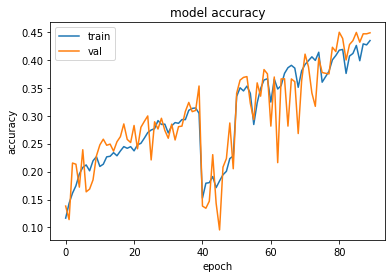

In [ ]:
plt.plot(PRELOADHIST['accuracy'])
plt.plot(PRELOADHIST['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

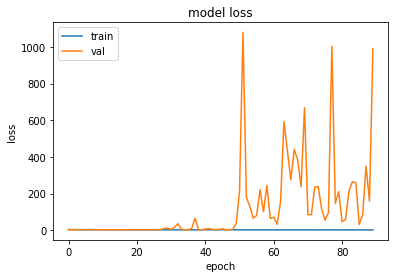

In [ ]:
plt.plot(PRELOADHIST['loss'])
plt.plot(PRELOADHIST['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Step 4: Use a Pre-trained Network with Transfer Learning
Now that you have a your own custom model and some baseline performance, let's see if you can improve the performance using transfer learning and a pre-trained model. You may use any pre-trained model EXCEPT ones that already provided such as `Xception`, `MobileNet`, `EfficientNetB6`. Keep in mind that each pre-trained model may expect a different input shape, so adjust the size of your training images accordingly.

Make sure you report the design of this architecture by answer the same questions 1-4 in Step 3.

Hint: use `ImageNet` as weights when load the pre-train network, then add a `GlobalAveragePooling2D` and an output layer with `softmax` activation.



## Base Questions Answers 

I'll be using a form of EfficientNetB3 as the model. This is for a couple reasons. The first is that it performs really well, the other is that it natively uses 300x300 size images so those are really the two things going for it. There's also this really handy guide that gives a high-level overview for how to use EfficientNet: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

Also, I read that we should use one-hot instead of categorical because labeled implies ordering. So one-hot is better. This change was made and repropagated to the above model. 

Also need to generate class_weights: 

In [ ]:
data_dir = "/content/dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 300; 
img_width = 300;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        

Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

y = np.concatenate([y for x, y in train_ds], axis=0)
train_class_weights = generate_class_weights(y, multi_class=True, one_hot_encoded=True)
print(train_class_weights)

{0: 1.9299223235393448, 1: 1.0689300411522633, 2: 1.6931851851851851, 3: 1.4496448503297819, 4: 3.670199100834939, 5: 1.924074074074074, 6: 0.943453855043751, 7: 2.1024650478292863, 8: 1.0307539682539681, 9: 1.2548309178743962, 10: 1.1042512077294686, 11: 0.9548036758563074, 12: 0.8140313390313391, 13: 0.5399187452758881, 14: 0.5027271927509457, 15: 0.6485642946317104, 16: 0.6492274483072029, 17: 0.9378795338913507}


The following code downloads, extracts, and generates a model using the noisy student weight parameters. 

|  Architecture  | @top1* Imagenet | @top1* Noisy-Student |
|:--------------:|-----------------|----------------------|
| EfficientNetB0 | 0.772           | 0.788                |
| EfficientNetB1 | 0.791           | 0.815                |
| EfficientNetB2 | 0.802           | 0.824                |
| EfficientNetB3 | 0.816           | 0.841                |
| EfficientNetB4 | 0.830           | 0.853                |
| EfficientNetB5 | 0.837           | 0.861                |
| EfficientNetB6 | 0.841           | 0.864                |
| EfficientNetB7 | 0.844           | 0.869                |

It was kind of annoying to load and get right but I feeld that a 3% improvement is worth it from the get-go. 

In [ ]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b3.tar.gz
!tar -xf noisy_student_efficientnet-b3.tar.gz

--2022-11-27 21:40:08--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b3.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90666967 (86M) [application/octet-stream]
Saving to: ‘noisy_student_efficientnet-b3.tar.gz’

noisy_student_effic 100%[===================>]  86.47M  23.7MB/s    in 4.7s    

2022-11-27 21:40:14 (18.5 MB/s) - ‘noisy_student_efficientnet-b3.tar.gz’ saved [90666967/90666967]



In [ ]:
!python efficientnet_weight_update_util.py --model b3 --notop --ckpt noisy_student_efficientnet-b3/model.ckpt --o noisy_student_efficientnetb3_notop.h5

2022-11-27 21:40:19.038965: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
43941136/43941136 [==============================] - 3s 0us/step
check variables match in each block
blocks_0 and block1a match.
blocks_1 and block1b match.
blocks_2 and block2a match.
blocks_3 and block2b match.
blocks_4 and block2c match.
blocks_5 and block3a match.
blocks_6 and block3b match.
blocks_7 and block3c match.
blocks_8 and block4a match.
blocks_9 and block4b match.
blocks_10 and block4c match.
blocks_11 and block4d match.
blocks_12 and block4e match.
blocks_13 and block5a match.
blocks_14 and block5b match.
blocks_15 and block5c match.
blocks_16 and block5d match.
blocks_17 and block5e match.
blocks_18 and block6a match.
blocks_19 and block6b match.
blocks_20 and block6c match.
blocks_21 and block6d match.
blocks_22 and block6e match.
blocks_23 and block6f matc

In [ ]:
# EfficientNetB3_model = tf.keras.models.EfficientNetB3(weights="noisy_student_efficientnetb3_notop.h5", 
#                                       include_top=False)

img_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation((-0.5, 0.5), "reflect", "bilinear"),
        tf.keras.layers.GaussianNoise(1), # making the stddev for this 10, can't see a diff with 1 
        # almost all other augmentations cause a while_loop error (so sad)
        # tf.keras.layers.RandomTranslation((-0.1, 0.1), (-0.1, 0.1), "nearest", "bilinear"),
        # tf.keras.layers.RandomZoom(height_factor=(0.0, 0.3), width_factor=(0.0, 0.3))
    ],
    name="img_augmentation",
)

IMG_SIZE = 300
NUM_CLASSES = 18
def build_model(num_classes):
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB3_model = tf.keras.applications.EfficientNetB3(weights="noisy_student_efficientnetb3_notop.h5", 
                                      input_tensor = x,
                                      include_top=False)

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  (None, 300, 300, 3)  0           ['input_9[0][0]']                
                                                                                                  
 rescaling_8 (Rescaling)        (None, 300, 300, 3)  0           ['img_augmentation[2][0]']       
                                                                                                  
 normalization_8 (Normalization  (None, 300, 300, 3)  7          ['rescaling_8[0][0]'] 

## Answering Architecture Questions
1.   How many layers does it have? 

EfficientNetV3 has 389 layers. With the last 5 being added layers with Normalization, Activation, Global Average pooling, another set of Normalization, Dropout, and finally a predictive layer. 

2.   Why do you decide on a certain number nodes per layer? 

Most of the model's node numbers were built-in but those were just from looking at stride/kernel/image input size following this equation: 

\begin{equation}
n_{out} = \left\lfloor \frac{n_{in} + 2 * p - k}{s} \right\rfloor + 1
\end{equation}

Where n_out/n_in are the nodes in/out p is the convolution padding size, k is the convolution kernel size, and s is the convolution stride size. 

The predictive layer's nodes are just set to the number of possible classes that any image can belong to. 

3.   Which activation functions do you choose? 

The activation function used most prominently in EfficientNet is the Smish function where the activation is 

\begin{equation}
f(x) = x*tanh(ln(1 + σ(x)))
\end{equation}

where sigma(x) is the sigmoid function. 

4.   How many parameters does it has in total?'

In total, the model has 10,817,345 total params, 1,970,802 of which are trainable, and 8,846,543 are trainable. 

Hint: use `myModel.summary()` to learn on the layers and parameters

Next, you will attempt to adapt this pre-trained model to your UVA Landmark dataset. It is recommended that you tried the two-phase training approach for your model:

1.   Phase 1: Freeze the pre-train weights and only train the top layer
2.   Phase 2: Train the entire network with much smaller learning rate (adapt the model to UVA data, but avoid destroying the transfered weights).



In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy


In [ ]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
history0 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, class_weight=train_class_weights, verbose=2)

Epoch 1/25
358/358 - 106s - loss: 2.6599 - accuracy: 0.5372 - val_loss: 1.3298 - val_accuracy: 0.6692 - 106s/epoch - 297ms/step
Epoch 2/25
358/358 - 93s - loss: 1.7046 - accuracy: 0.6325 - val_loss: 1.3260 - val_accuracy: 0.6860 - 93s/epoch - 260ms/step
Epoch 3/25
358/358 - 93s - loss: 1.3001 - accuracy: 0.6677 - val_loss: 1.1127 - val_accuracy: 0.7060 - 93s/epoch - 261ms/step
Epoch 4/25
358/358 - 93s - loss: 1.1914 - accuracy: 0.6681 - val_loss: 1.1635 - val_accuracy: 0.6839 - 93s/epoch - 260ms/step
Epoch 5/25
358/358 - 94s - loss: 1.1595 - accuracy: 0.6783 - val_loss: 1.0656 - val_accuracy: 0.7098 - 94s/epoch - 261ms/step
Epoch 6/25
358/358 - 93s - loss: 1.1711 - accuracy: 0.6750 - val_loss: 1.0390 - val_accuracy: 0.7109 - 93s/epoch - 261ms/step
Epoch 7/25
358/358 - 94s - loss: 1.1719 - accuracy: 0.6784 - val_loss: 1.0813 - val_accuracy: 0.7179 - 94s/epoch - 262ms/step
Epoch 8/25
358/358 - 93s - loss: 1.1670 - accuracy: 0.6757 - val_loss: 0.9694 - val_accuracy: 0.7333 - 93s/epoch - 2

The above training plateaus after about 5 epochs and actually goes backward around near 10 epochs so the epochs shouldn't be as high as they are right now. 

In [ ]:
model.save("/content/step0_model.h5")

In [ ]:
unfreeze_model(model)

epochs = 20  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, class_weight=train_class_weights, verbose=2)

Epoch 1/20
358/358 - 116s - loss: 0.9813 - accuracy: 0.7379 - val_loss: 0.7390 - val_accuracy: 0.8117 - 116s/epoch - 325ms/step
Epoch 2/20
358/358 - 99s - loss: 0.7831 - accuracy: 0.7821 - val_loss: 0.6696 - val_accuracy: 0.8306 - 99s/epoch - 276ms/step
Epoch 3/20
358/358 - 99s - loss: 0.6903 - accuracy: 0.7986 - val_loss: 0.6040 - val_accuracy: 0.8383 - 99s/epoch - 276ms/step
Epoch 4/20
358/358 - 99s - loss: 0.6358 - accuracy: 0.8112 - val_loss: 0.5613 - val_accuracy: 0.8593 - 99s/epoch - 277ms/step
Epoch 5/20
358/358 - 99s - loss: 0.6017 - accuracy: 0.8243 - val_loss: 0.5607 - val_accuracy: 0.8502 - 99s/epoch - 275ms/step
Epoch 6/20
358/358 - 99s - loss: 0.5503 - accuracy: 0.8313 - val_loss: 0.5042 - val_accuracy: 0.8743 - 99s/epoch - 276ms/step
Epoch 7/20
358/358 - 99s - loss: 0.5513 - accuracy: 0.8369 - val_loss: 0.5024 - val_accuracy: 0.8722 - 99s/epoch - 277ms/step
Epoch 8/20
358/358 - 99s - loss: 0.5107 - accuracy: 0.8454 - val_loss: 0.5020 - val_accuracy: 0.8712 - 99s/epoch - 2

In [ ]:
model.save("/content/step1_model.h5")

I think with a couple more epochs, we can get some bonus points so I'll train for another 20. 

In [ ]:
epochs = 20  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, class_weight=train_class_weights, verbose=2)

Epoch 1/20
358/358 - 100s - loss: 0.2905 - accuracy: 0.9105 - val_loss: 0.3715 - val_accuracy: 0.9160 - 100s/epoch - 279ms/step
Epoch 2/20
358/358 - 99s - loss: 0.2989 - accuracy: 0.9073 - val_loss: 0.3893 - val_accuracy: 0.9079 - 99s/epoch - 277ms/step
Epoch 3/20
358/358 - 99s - loss: 0.2816 - accuracy: 0.9109 - val_loss: 0.3720 - val_accuracy: 0.9174 - 99s/epoch - 276ms/step
Epoch 4/20
358/358 - 99s - loss: 0.2733 - accuracy: 0.9150 - val_loss: 0.3653 - val_accuracy: 0.9163 - 99s/epoch - 277ms/step
Epoch 5/20
358/358 - 99s - loss: 0.2756 - accuracy: 0.9122 - val_loss: 0.3756 - val_accuracy: 0.9146 - 99s/epoch - 276ms/step
Epoch 6/20
358/358 - 99s - loss: 0.2645 - accuracy: 0.9145 - val_loss: 0.3580 - val_accuracy: 0.9188 - 99s/epoch - 276ms/step
Epoch 7/20
358/358 - 99s - loss: 0.2536 - accuracy: 0.9192 - val_loss: 0.3682 - val_accuracy: 0.9128 - 99s/epoch - 276ms/step
Epoch 8/20
358/358 - 99s - loss: 0.2540 - accuracy: 0.9192 - val_loss: 0.3485 - val_accuracy: 0.9230 - 99s/epoch - 2

In [ ]:
model.save("/content/step2_model.h5")

In [ ]:
model = keras.models.load_model("/content/step2_model.h5")
model.trainable = True

In [12]:
epochs = 50

hist = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, class_weight=train_class_weights, verbose=2)

Epoch 1/50
358/358 - 103s - loss: 0.1694 - accuracy: 0.9465 - val_loss: 0.3296 - val_accuracy: 0.9279 - 103s/epoch - 287ms/step
Epoch 2/50
358/358 - 101s - loss: 0.1642 - accuracy: 0.9461 - val_loss: 0.3152 - val_accuracy: 0.9324 - 101s/epoch - 283ms/step
Epoch 3/50
358/358 - 102s - loss: 0.1636 - accuracy: 0.9501 - val_loss: 0.3115 - val_accuracy: 0.9296 - 102s/epoch - 284ms/step
Epoch 4/50
358/358 - 101s - loss: 0.1672 - accuracy: 0.9450 - val_loss: 0.3234 - val_accuracy: 0.9342 - 101s/epoch - 283ms/step
Epoch 5/50
358/358 - 101s - loss: 0.1539 - accuracy: 0.9501 - val_loss: 0.3379 - val_accuracy: 0.9303 - 101s/epoch - 283ms/step
Epoch 6/50
358/358 - 101s - loss: 0.1558 - accuracy: 0.9504 - val_loss: 0.3290 - val_accuracy: 0.9328 - 101s/epoch - 283ms/step
Epoch 7/50
358/358 - 101s - loss: 0.1474 - accuracy: 0.9533 - val_loss: 0.3392 - val_accuracy: 0.9247 - 101s/epoch - 283ms/step
Epoch 8/50
358/358 - 101s - loss: 0.1376 - accuracy: 0.9543 - val_loss: 0.3099 - val_accuracy: 0.9352 - 

In [13]:
model.save("/content/step3_model.h5")

##Repeat the same reporting of performance using the confusion matrix:

- Did this pre-trained network do better overall? 

This pre-trained matrix does do better overall. It has higher accuracies and a lower loss than the custom model. We actually end up with a validation accuracy of %94.61

- In which class it improve the accuracy from the above model? 

As expected, the model still has issues classifying the Rotunda vs the Academical Village. But overall, the model does better: 
  - Rotunda as Academic Village: 42
  - Rotunda as Old Cabell: 20
  - Thornton as Olsson: 20
  - Rice Hall as Scott Stadium: 20
  - Thornton as Scott Stadium: 12
  - Scott Stadium as Madison Hall: 11
  - Scott Stadium as Academic Village: 11
  - Thornton as New Cabell: 11

We have significant improvements in all classes. Particularly in classifying Clark Hall. 

- Which class still has low performance? 

Interestingly, we still continue to misclass Rotunda and Scott Stadium. The Rotunda I understand due to similar architectures and overlapping features but Scott Stadium I still don't understand. Actually there are exactly 11 pictures in the Scott Stadium directory that are actually the Academic Village so that part makes sense. 

We also have low performance in Thornton hall (like before) but I can't explain that poor performance. 

Typically, your network must have a reasonable performance of at least 84% overall accuracy to be considered successful in this domain. If your network achieves a accuracy of 94% or above on the validation set, you will also recieve a 10 bonus points, so keep trying!

Sample code to plot loss/accuracy: https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

Sample code for confusion matrix: https://www.kaggle.com/code/mdmashurshalehin/plotting-confusion-matrix-for-tensorflow-model/notebook?scriptVersionId=63046076&cellId=16

and

To actually extract the data from the dataset. 
https://stackoverflow.com/questions/64622210/how-to-extract-classes-from-prefetched-dataset-in-tensorflow-for-confusion-matri 



In [22]:
# extracting all the data: 
IMG_SIZE=300
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    seed = 42, 
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size, 
    shuffle=False
)

Found 14286 files belonging to 18 classes.


In [23]:
y_pred = model.predict(test_ds).argmax(axis=-1)
test_labels = np.argmax(np.concatenate([y for x, y in test_ds], axis = 0), axis=1)

447/447 [==============================] - 97s 213ms/step


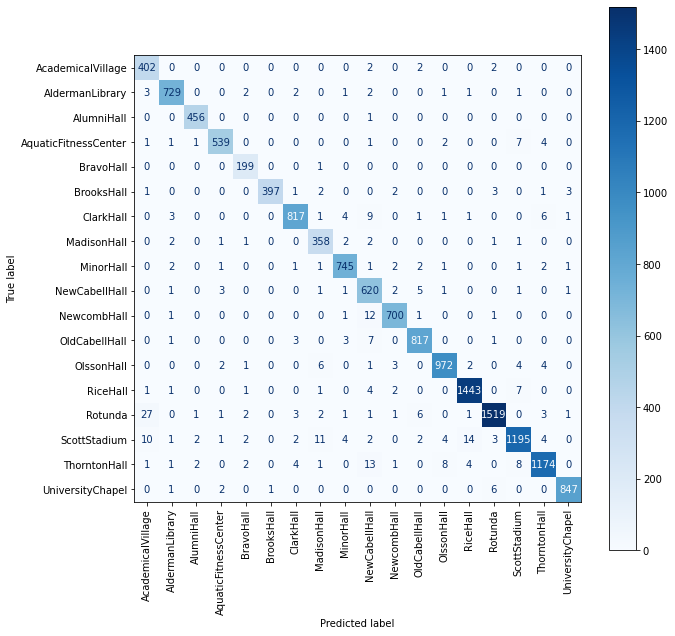

In [24]:
# from: https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

labels = train_ds.class_names
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xticks(rotation = 90)
plt.show()

In [25]:
print("Evaluate on test data")
results = model.evaluate(train_ds, batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data
358/358 [==============================] - 80s 221ms/step - loss: 0.0680 - accuracy: 0.9826
test loss, test acc: [0.0679975152015686, 0.9825881719589233]


In [16]:
# Slight issue, cleared the runtime before generating the loss plots so instead 
# I have to use a python script that manually extracts the values from the
# .fit() training text output

s1 = "Epoch 1/25 358/358 - 106s - loss: 2.6599 - accuracy: 0.5372 - val_loss: 1.3298 - val_accuracy: 0.6692 - 106s/epoch - 297ms/step Epoch 2/25 358/358 - 93s - loss: 1.7046 - accuracy: 0.6325 - val_loss: 1.3260 - val_accuracy: 0.6860 - 93s/epoch - 260ms/step Epoch 3/25 358/358 - 93s - loss: 1.3001 - accuracy: 0.6677 - val_loss: 1.1127 - val_accuracy: 0.7060 - 93s/epoch - 261ms/step Epoch 4/25 358/358 - 93s - loss: 1.1914 - accuracy: 0.6681 - val_loss: 1.1635 - val_accuracy: 0.6839 - 93s/epoch - 260ms/step Epoch 5/25 358/358 - 94s - loss: 1.1595 - accuracy: 0.6783 - val_loss: 1.0656 - val_accuracy: 0.7098 - 94s/epoch - 261ms/step Epoch 6/25 358/358 - 93s - loss: 1.1711 - accuracy: 0.6750 - val_loss: 1.0390 - val_accuracy: 0.7109 - 93s/epoch - 261ms/step Epoch 7/25 358/358 - 94s - loss: 1.1719 - accuracy: 0.6784 - val_loss: 1.0813 - val_accuracy: 0.7179 - 94s/epoch - 262ms/step Epoch 8/25 358/358 - 93s - loss: 1.1670 - accuracy: 0.6757 - val_loss: 0.9694 - val_accuracy: 0.7333 - 93s/epoch - 261ms/step Epoch 9/25 358/358 - 93s - loss: 1.1899 - accuracy: 0.6736 - val_loss: 1.0325 - val_accuracy: 0.7200 - 93s/epoch - 260ms/step Epoch 10/25 358/358 - 93s - loss: 1.2181 - accuracy: 0.6719 - val_loss: 1.0778 - val_accuracy: 0.7165 - 93s/epoch - 261ms/step Epoch 11/25 358/358 - 93s - loss: 1.2331 - accuracy: 0.6727 - val_loss: 0.9490 - val_accuracy: 0.7336 - 93s/epoch - 260ms/step Epoch 12/25 358/358 - 93s - loss: 1.1973 - accuracy: 0.6721 - val_loss: 1.1131 - val_accuracy: 0.7137 - 93s/epoch - 260ms/step Epoch 13/25 358/358 - 93s - loss: 1.3105 - accuracy: 0.6631 - val_loss: 1.2442 - val_accuracy: 0.6853 - 93s/epoch - 261ms/step Epoch 14/25 358/358 - 94s - loss: 1.2044 - accuracy: 0.6752 - val_loss: 1.2059 - val_accuracy: 0.6717 - 94s/epoch - 263ms/step Epoch 15/25 358/358 - 93s - loss: 1.2945 - accuracy: 0.6601 - val_loss: 1.1700 - val_accuracy: 0.7175 - 93s/epoch - 261ms/step Epoch 16/25 358/358 - 93s - loss: 1.2142 - accuracy: 0.6721 - val_loss: 1.0554 - val_accuracy: 0.7291 - 93s/epoch - 261ms/step Epoch 17/25 358/358 - 93s - loss: 1.2825 - accuracy: 0.6652 - val_loss: 1.2500 - val_accuracy: 0.6850 - 93s/epoch - 260ms/step Epoch 18/25 358/358 - 94s - loss: 1.2712 - accuracy: 0.6671 - val_loss: 1.0572 - val_accuracy: 0.7175 - 94s/epoch - 262ms/step Epoch 19/25 358/358 - 94s - loss: 1.2690 - accuracy: 0.6682 - val_loss: 1.1308 - val_accuracy: 0.6997 - 94s/epoch - 263ms/step Epoch 20/25 358/358 - 94s - loss: 1.2399 - accuracy: 0.6696 - val_loss: 0.9791 - val_accuracy: 0.7455 - 94s/epoch - 262ms/step Epoch 21/25 358/358 - 94s - loss: 1.2880 - accuracy: 0.6676 - val_loss: 1.1838 - val_accuracy: 0.7025 - 94s/epoch - 262ms/step Epoch 22/25 358/358 - 93s - loss: 1.2425 - accuracy: 0.6716 - val_loss: 1.1623 - val_accuracy: 0.7123 - 93s/epoch - 260ms/step Epoch 23/25 358/358 - 93s - loss: 1.3203 - accuracy: 0.6672 - val_loss: 1.0473 - val_accuracy: 0.7396 - 93s/epoch - 260ms/step Epoch 24/25 358/358 - 93s - loss: 1.2635 - accuracy: 0.6665 - val_loss: 1.1358 - val_accuracy: 0.7147 - 93s/epoch - 261ms/step Epoch 25/25 358/358 - 93s - loss: 1.2687 - accuracy: 0.6722 - val_loss: 1.2715 - val_accuracy: 0.6836 - 93s/epoch - 260ms/step"
s2 = "Epoch 1/20 358/358 - 116s - loss: 0.9813 - accuracy: 0.7379 - val_loss: 0.7390 - val_accuracy: 0.8117 - 116s/epoch - 325ms/step Epoch 2/20 358/358 - 99s - loss: 0.7831 - accuracy: 0.7821 - val_loss: 0.6696 - val_accuracy: 0.8306 - 99s/epoch - 276ms/step Epoch 3/20 358/358 - 99s - loss: 0.6903 - accuracy: 0.7986 - val_loss: 0.6040 - val_accuracy: 0.8383 - 99s/epoch - 276ms/step Epoch 4/20 358/358 - 99s - loss: 0.6358 - accuracy: 0.8112 - val_loss: 0.5613 - val_accuracy: 0.8593 - 99s/epoch - 277ms/step Epoch 5/20 358/358 - 99s - loss: 0.6017 - accuracy: 0.8243 - val_loss: 0.5607 - val_accuracy: 0.8502 - 99s/epoch - 275ms/step Epoch 6/20 358/358 - 99s - loss: 0.5503 - accuracy: 0.8313 - val_loss: 0.5042 - val_accuracy: 0.8743 - 99s/epoch - 276ms/step Epoch 7/20 358/358 - 99s - loss: 0.5513 - accuracy: 0.8369 - val_loss: 0.5024 - val_accuracy: 0.8722 - 99s/epoch - 277ms/step Epoch 8/20 358/358 - 99s - loss: 0.5107 - accuracy: 0.8454 - val_loss: 0.5020 - val_accuracy: 0.8712 - 99s/epoch - 276ms/step Epoch 9/20 358/358 - 99s - loss: 0.4829 - accuracy: 0.8545 - val_loss: 0.4733 - val_accuracy: 0.8796 - 99s/epoch - 276ms/step Epoch 10/20 358/358 - 99s - loss: 0.4462 - accuracy: 0.8625 - val_loss: 0.4609 - val_accuracy: 0.8866 - 99s/epoch - 277ms/step Epoch 11/20 358/358 - 99s - loss: 0.4294 - accuracy: 0.8693 - val_loss: 0.4716 - val_accuracy: 0.8810 - 99s/epoch - 276ms/step Epoch 12/20 358/358 - 99s - loss: 0.4046 - accuracy: 0.8752 - val_loss: 0.4399 - val_accuracy: 0.8936 - 99s/epoch - 276ms/step Epoch 13/20 358/358 - 99s - loss: 0.4102 - accuracy: 0.8750 - val_loss: 0.4461 - val_accuracy: 0.8929 - 99s/epoch - 276ms/step Epoch 14/20 358/358 - 99s - loss: 0.3853 - accuracy: 0.8842 - val_loss: 0.4380 - val_accuracy: 0.8988 - 99s/epoch - 277ms/step Epoch 15/20 358/358 - 99s - loss: 0.3742 - accuracy: 0.8821 - val_loss: 0.4390 - val_accuracy: 0.9013 - 99s/epoch - 275ms/step Epoch 16/20 358/358 - 99s - loss: 0.3780 - accuracy: 0.8828 - val_loss: 0.4191 - val_accuracy: 0.9006 - 99s/epoch - 276ms/step Epoch 17/20 358/358 - 99s - loss: 0.3495 - accuracy: 0.8950 - val_loss: 0.4240 - val_accuracy: 0.9002 - 99s/epoch - 276ms/step Epoch 18/20 358/358 - 101s - loss: 0.3361 - accuracy: 0.8975 - val_loss: 0.4046 - val_accuracy: 0.9027 - 101s/epoch - 282ms/step Epoch 19/20 358/358 - 99s - loss: 0.3146 - accuracy: 0.9010 - val_loss: 0.3893 - val_accuracy: 0.9121 - 99s/epoch - 276ms/step Epoch 20/20 358/358 - 99s - loss: 0.3109 - accuracy: 0.9028 - val_loss: 0.3893 - val_accuracy: 0.9111 - 99s/epoch - 276ms/step"
s3 = "Epoch 1/20 358/358 - 100s - loss: 0.2905 - accuracy: 0.9105 - val_loss: 0.3715 - val_accuracy: 0.9160 - 100s/epoch - 279ms/step Epoch 2/20 358/358 - 99s - loss: 0.2989 - accuracy: 0.9073 - val_loss: 0.3893 - val_accuracy: 0.9079 - 99s/epoch - 277ms/step Epoch 3/20 358/358 - 99s - loss: 0.2816 - accuracy: 0.9109 - val_loss: 0.3720 - val_accuracy: 0.9174 - 99s/epoch - 276ms/step Epoch 4/20 358/358 - 99s - loss: 0.2733 - accuracy: 0.9150 - val_loss: 0.3653 - val_accuracy: 0.9163 - 99s/epoch - 277ms/step Epoch 5/20 358/358 - 99s - loss: 0.2756 - accuracy: 0.9122 - val_loss: 0.3756 - val_accuracy: 0.9146 - 99s/epoch - 276ms/step Epoch 6/20 358/358 - 99s - loss: 0.2645 - accuracy: 0.9145 - val_loss: 0.3580 - val_accuracy: 0.9188 - 99s/epoch - 276ms/step Epoch 7/20 358/358 - 99s - loss: 0.2536 - accuracy: 0.9192 - val_loss: 0.3682 - val_accuracy: 0.9128 - 99s/epoch - 276ms/step Epoch 8/20 358/358 - 99s - loss: 0.2540 - accuracy: 0.9192 - val_loss: 0.3485 - val_accuracy: 0.9230 - 99s/epoch - 276ms/step Epoch 9/20 358/358 - 99s - loss: 0.2676 - accuracy: 0.9189 - val_loss: 0.3557 - val_accuracy: 0.9191 - 99s/epoch - 276ms/step Epoch 10/20 358/358 - 99s - loss: 0.2396 - accuracy: 0.9227 - val_loss: 0.3582 - val_accuracy: 0.9177 - 99s/epoch - 276ms/step Epoch 11/20 358/358 - 99s - loss: 0.2467 - accuracy: 0.9216 - val_loss: 0.3493 - val_accuracy: 0.9216 - 99s/epoch - 276ms/step Epoch 12/20 358/358 - 99s - loss: 0.2226 - accuracy: 0.9283 - val_loss: 0.3514 - val_accuracy: 0.9191 - 99s/epoch - 277ms/step Epoch 13/20 358/358 - 99s - loss: 0.2176 - accuracy: 0.9308 - val_loss: 0.3592 - val_accuracy: 0.9139 - 99s/epoch - 276ms/step Epoch 14/20 358/358 - 99s - loss: 0.2202 - accuracy: 0.9322 - val_loss: 0.3572 - val_accuracy: 0.9191 - 99s/epoch - 276ms/step Epoch 15/20 358/358 - 99s - loss: 0.2123 - accuracy: 0.9334 - val_loss: 0.3345 - val_accuracy: 0.9282 - 99s/epoch - 276ms/step Epoch 16/20 358/358 - 99s - loss: 0.2101 - accuracy: 0.9345 - val_loss: 0.3291 - val_accuracy: 0.9237 - 99s/epoch - 277ms/step Epoch 17/20 358/358 - 99s - loss: 0.1999 - accuracy: 0.9341 - val_loss: 0.3486 - val_accuracy: 0.9202 - 99s/epoch - 276ms/step Epoch 18/20 358/358 - 99s - loss: 0.1986 - accuracy: 0.9372 - val_loss: 0.3395 - val_accuracy: 0.9282 - 99s/epoch - 276ms/step Epoch 19/20 358/358 - 99s - loss: 0.1853 - accuracy: 0.9389 - val_loss: 0.3380 - val_accuracy: 0.9258 - 99s/epoch - 276ms/step Epoch 20/20 358/358 - 99s - loss: 0.1814 - accuracy: 0.9411 - val_loss: 0.3290 - val_accuracy: 0.9338 - 99s/epoch - 277ms/step"
s5 = "Epoch 1/50 358/358 - 103s - loss: 0.1694 - accuracy: 0.9465 - val_loss: 0.3296 - val_accuracy: 0.9279 - 103s/epoch - 287ms/step Epoch 2/50 358/358 - 101s - loss: 0.1642 - accuracy: 0.9461 - val_loss: 0.3152 - val_accuracy: 0.9324 - 101s/epoch - 283ms/step Epoch 3/50 358/358 - 102s - loss: 0.1636 - accuracy: 0.9501 - val_loss: 0.3115 - val_accuracy: 0.9296 - 102s/epoch - 284ms/step Epoch 4/50 358/358 - 101s - loss: 0.1672 - accuracy: 0.9450 - val_loss: 0.3234 - val_accuracy: 0.9342 - 101s/epoch - 283ms/step Epoch 5/50 358/358 - 101s - loss: 0.1539 - accuracy: 0.9501 - val_loss: 0.3379 - val_accuracy: 0.9303 - 101s/epoch - 283ms/step Epoch 6/50 358/358 - 101s - loss: 0.1558 - accuracy: 0.9504 - val_loss: 0.3290 - val_accuracy: 0.9328 - 101s/epoch - 283ms/step Epoch 7/50 358/358 - 101s - loss: 0.1474 - accuracy: 0.9533 - val_loss: 0.3392 - val_accuracy: 0.9247 - 101s/epoch - 283ms/step Epoch 8/50 358/358 - 101s - loss: 0.1376 - accuracy: 0.9543 - val_loss: 0.3099 - val_accuracy: 0.9352 - 101s/epoch - 283ms/step Epoch 9/50 358/358 - 102s - loss: 0.1408 - accuracy: 0.9525 - val_loss: 0.3142 - val_accuracy: 0.9310 - 102s/epoch - 284ms/step Epoch 10/50 358/358 - 102s - loss: 0.1390 - accuracy: 0.9562 - val_loss: 0.3146 - val_accuracy: 0.9331 - 102s/epoch - 284ms/step Epoch 11/50 358/358 - 101s - loss: 0.1423 - accuracy: 0.9542 - val_loss: 0.3103 - val_accuracy: 0.9349 - 101s/epoch - 283ms/step Epoch 12/50 358/358 - 101s - loss: 0.1358 - accuracy: 0.9568 - val_loss: 0.3187 - val_accuracy: 0.9363 - 101s/epoch - 283ms/step Epoch 13/50 358/358 - 101s - loss: 0.1267 - accuracy: 0.9570 - val_loss: 0.3089 - val_accuracy: 0.9349 - 101s/epoch - 283ms/step Epoch 14/50 358/358 - 102s - loss: 0.1246 - accuracy: 0.9602 - val_loss: 0.3043 - val_accuracy: 0.9345 - 102s/epoch - 284ms/step Epoch 15/50 358/358 - 101s - loss: 0.1306 - accuracy: 0.9567 - val_loss: 0.3112 - val_accuracy: 0.9342 - 101s/epoch - 284ms/step Epoch 16/50 358/358 - 101s - loss: 0.1296 - accuracy: 0.9570 - val_loss: 0.3134 - val_accuracy: 0.9352 - 101s/epoch - 283ms/step Epoch 17/50 358/358 - 101s - loss: 0.1266 - accuracy: 0.9585 - val_loss: 0.3238 - val_accuracy: 0.9335 - 101s/epoch - 283ms/step Epoch 18/50 358/358 - 101s - loss: 0.1319 - accuracy: 0.9563 - val_loss: 0.3007 - val_accuracy: 0.9335 - 101s/epoch - 283ms/step Epoch 19/50 358/358 - 102s - loss: 0.1261 - accuracy: 0.9600 - val_loss: 0.2870 - val_accuracy: 0.9394 - 102s/epoch - 284ms/step Epoch 20/50 358/358 - 101s - loss: 0.1181 - accuracy: 0.9622 - val_loss: 0.2968 - val_accuracy: 0.9398 - 101s/epoch - 283ms/step Epoch 21/50 358/358 - 102s - loss: 0.1155 - accuracy: 0.9616 - val_loss: 0.2887 - val_accuracy: 0.9412 - 102s/epoch - 284ms/step Epoch 22/50 358/358 - 101s - loss: 0.1056 - accuracy: 0.9641 - val_loss: 0.3290 - val_accuracy: 0.9282 - 101s/epoch - 283ms/step Epoch 23/50 358/358 - 101s - loss: 0.1138 - accuracy: 0.9620 - val_loss: 0.2967 - val_accuracy: 0.9433 - 101s/epoch - 283ms/step Epoch 24/50 358/358 - 102s - loss: 0.1127 - accuracy: 0.9639 - val_loss: 0.2994 - val_accuracy: 0.9342 - 102s/epoch - 284ms/step Epoch 25/50 358/358 - 101s - loss: 0.1040 - accuracy: 0.9657 - val_loss: 0.2953 - val_accuracy: 0.9377 - 101s/epoch - 283ms/step Epoch 26/50 358/358 - 101s - loss: 0.1045 - accuracy: 0.9640 - val_loss: 0.3123 - val_accuracy: 0.9352 - 101s/epoch - 283ms/step Epoch 27/50 358/358 - 102s - loss: 0.1059 - accuracy: 0.9640 - val_loss: 0.3184 - val_accuracy: 0.9345 - 102s/epoch - 284ms/step Epoch 28/50 358/358 - 101s - loss: 0.1064 - accuracy: 0.9647 - val_loss: 0.3105 - val_accuracy: 0.9398 - 101s/epoch - 283ms/step Epoch 29/50 358/358 - 102s - loss: 0.1093 - accuracy: 0.9638 - val_loss: 0.2987 - val_accuracy: 0.9387 - 102s/epoch - 284ms/step Epoch 30/50 358/358 - 101s - loss: 0.1069 - accuracy: 0.9660 - val_loss: 0.3117 - val_accuracy: 0.9370 - 101s/epoch - 283ms/step Epoch 31/50 358/358 - 102s - loss: 0.1075 - accuracy: 0.9647 - val_loss: 0.3283 - val_accuracy: 0.9359 - 102s/epoch - 284ms/step Epoch 32/50 358/358 - 102s - loss: 0.0963 - accuracy: 0.9672 - val_loss: 0.3067 - val_accuracy: 0.9405 - 102s/epoch - 284ms/step Epoch 33/50 358/358 - 102s - loss: 0.1068 - accuracy: 0.9644 - val_loss: 0.2941 - val_accuracy: 0.9412 - 102s/epoch - 284ms/step Epoch 34/50 358/358 - 101s - loss: 0.0973 - accuracy: 0.9672 - val_loss: 0.3015 - val_accuracy: 0.9387 - 101s/epoch - 283ms/step Epoch 35/50 358/358 - 101s - loss: 0.0959 - accuracy: 0.9647 - val_loss: 0.2978 - val_accuracy: 0.9356 - 101s/epoch - 283ms/step Epoch 36/50 358/358 - 101s - loss: 0.0948 - accuracy: 0.9680 - val_loss: 0.2971 - val_accuracy: 0.9387 - 101s/epoch - 283ms/step Epoch 37/50 358/358 - 101s - loss: 0.1046 - accuracy: 0.9661 - val_loss: 0.3045 - val_accuracy: 0.9426 - 101s/epoch - 283ms/step Epoch 38/50 358/358 - 101s - loss: 0.0945 - accuracy: 0.9671 - val_loss: 0.2931 - val_accuracy: 0.9436 - 101s/epoch - 283ms/step Epoch 39/50 358/358 - 102s - loss: 0.0949 - accuracy: 0.9688 - val_loss: 0.3007 - val_accuracy: 0.9426 - 102s/epoch - 284ms/step Epoch 40/50 358/358 - 101s - loss: 0.0960 - accuracy: 0.9670 - val_loss: 0.3084 - val_accuracy: 0.9405 - 101s/epoch - 284ms/step Epoch 41/50 358/358 - 101s - loss: 0.0884 - accuracy: 0.9696 - val_loss: 0.2998 - val_accuracy: 0.9429 - 101s/epoch - 283ms/step Epoch 42/50 358/358 - 102s - loss: 0.0834 - accuracy: 0.9703 - val_loss: 0.3110 - val_accuracy: 0.9405 - 102s/epoch - 284ms/step Epoch 43/50 358/358 - 101s - loss: 0.0890 - accuracy: 0.9701 - val_loss: 0.3109 - val_accuracy: 0.9398 - 101s/epoch - 283ms/step Epoch 44/50 358/358 - 101s - loss: 0.0944 - accuracy: 0.9665 - val_loss: 0.3074 - val_accuracy: 0.9370 - 101s/epoch - 283ms/step Epoch 45/50 358/358 - 101s - loss: 0.0907 - accuracy: 0.9692 - val_loss: 0.3084 - val_accuracy: 0.9377 - 101s/epoch - 283ms/step Epoch 46/50 358/358 - 101s - loss: 0.0817 - accuracy: 0.9713 - val_loss: 0.3028 - val_accuracy: 0.9461 - 101s/epoch - 283ms/step Epoch 47/50 358/358 - 102s - loss: 0.0844 - accuracy: 0.9714 - val_loss: 0.2853 - val_accuracy: 0.9454 - 102s/epoch - 284ms/step Epoch 48/50 358/358 - 102s - loss: 0.0900 - accuracy: 0.9699 - val_loss: 0.2998 - val_accuracy: 0.9447 - 102s/epoch - 284ms/step Epoch 49/50 358/358 - 101s - loss: 0.0834 - accuracy: 0.9717 - val_loss: 0.3027 - val_accuracy: 0.9447 - 101s/epoch - 283ms/step Epoch 50/50 358/358 - 101s - loss: 0.0770 - accuracy: 0.9735 - val_loss: 0.3046 - val_accuracy: 0.9447 - 101s/epoch - 283ms/step"


ENB3history = {}
ENB3history['loss'] = []
ENB3history['accuracy'] = []
ENB3history['val_loss'] = []
ENB3history['val_accuracy'] = []

def addToDict(history, s): 
  splitString = s.split(":")
  for i in range(0, len(splitString)): 
      if ( i == 0 ): 
          continue
      history[list(history.keys())[i % 4 - 1]].append(splitString[i][1:7])
      
  return history

addToDict(ENB3history, s1)
addToDict(ENB3history, s2)
addToDict(ENB3history, s3)
addToDict(ENB3history, s5)

ENB3history['loss'] = [float(x) for x in ENB3history['loss']]
ENB3history['accuracy'] = [float(x) for x in ENB3history['accuracy']]
ENB3history['val_loss'] = [float(x) for x in ENB3history['val_loss']]
ENB3history['val_accuracy'] = [float(x) for x in ENB3history['val_accuracy']]

In [19]:
max(ENB3history['val_accuracy'])

0.9461

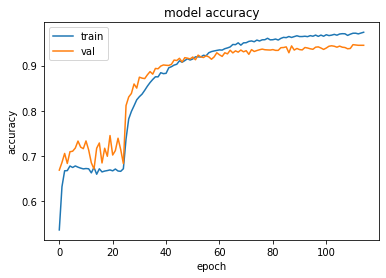

In [17]:
plt.plot(ENB3history['accuracy'])
plt.plot(ENB3history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

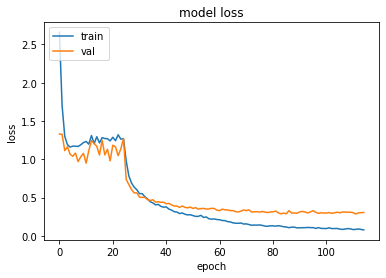

In [18]:
plt.plot(ENB3history['loss'])
plt.plot(ENB3history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Step 5: Reflection

Write at least a paragraph answering these prompts: How did your own network perform in comparison to the pre-trained one? What are the major differences between the architectures? Additionally, report on your experience implementing different models for this assignment (Was it hard/easy/fun?, from which part did you learn the most?)!

How did your own network perform in comparison to the pre-trained one? What are the major differences between the architectures? Additionally, report on your experience implementing different models for this assignment (Was it hard/easy/fun?, from which part did you learn the most?)

My network did not perform as well as the pre-trained one (obv). My network was able to attain a validation accuracy of about 71% while the pre-trained was able to exceed 94%. 

Major differences in architectures have to do with the shear size of EfficientNet and the arrangement of its various modules. I think the biggest structural difference is Efficient Net's use of two different types of convolutions: Depthwise Convolution + Pointwise Convolution. These divide the original convolution into separate "stages." Doing so reduces the cost of calculation and improves accuracy. 

Another aspect is the fact that EfficientNet has an "expandable" architecture that can be expanded width-wise (to handle higher-dimension images) and length-wise (to offer more processing within images) this expandable architecture enables the model to adapt to various data-dimensions and specificities. 

But I think the biggest difference is how the two were trained. EfficientNet, being a pre-trained model, was able to be trained on a variety of images that ultimately improves its ability to pick-up on a wide variety of features. 

In terms of my experience I feel like I learned a lot. What happened earlier is that I lost my first notebook due to permissions issues and lost a lot of work. In that notebook I was able to get my custom model to about 90% accuracy which was amazing. All it cost was 10$ worth of Google Credits :(. But I learned a lot from that. Specifically, I learned that I needed to address the fact that the classes had unbalanced numbers of images. This forced me to create a class_weights variable that adjusted the class weighting during training. 

Something else I learned was that BatchNormalization significantly improves training ability. I would add that to the EfficientNet model I have but I think its a little late for that. But adding BatchNormalization improved performance for the custom model which was great. 

I also learned a lot about callbacks and the optimal methods to tune a keras model including turning off the training for some parts while allowing other parts to train and vice versa. 

If I could do this again, I would want to use the various data augmentation methods during training my models. Right now there is a bug with keras which forces the data augmentation methods to use a while_loop. This results in longer training time which I really can't afford. So I had to use some of the more basic augmentations.

If I had more time, I would also clean out the data by hand. Personally, I have spotted over 12 images that are mis-labeled/mis-classified which probably wreak havoc on the training. Removing/properly placing those images would probably help the model. 